# Evaluation of first implementation

* [Attention visualisation](#Attention-visualisation)
  * [Code to create the visualisation](#Code-to-create-the-visualisation)
  * [Visualisation of differently trained models](#Visualisation-of-differently-trained-models)
    * [Attention on training set](#Attention-on-training-set)
    * [Attention on test set 2013](#Attention-on-test-set-2013)
    * [Attention on test set 2016](#Attention-on-test-set-2016)
* [Observations](#Observations)
* [Evaluation of the model](#Evaluation-of-the-model)
  * [Sequence example](#Sequence-example)
  * [Training set](#Training-set)
  * [Test set 2013](#Test-set-2013)
  * [Test set 2014](#Test-set-2014)
  * [Test set 2016](#Test-set-2016)
* [Conclusion](#Conclusion)
  * [Attention](#Attention)
  * [Models](#Models)
  * [Sequence length](#Sequence-length)
* [Next steps](#Next-steps)
  * [Evaluate the fixed dropout version (standard DenseNet dropout)](#Evaluate-the-fixed-dropout-version-(standard-DenseNet-dropout))
  * [Beam search](#Beam-search)
  * [CROHME evaluation tool](#CROHME-evaluation-tool)
  * [Tutoring data](#Tutoring-data)


In [1]:
%%html
<!-- Left aligns the markdown tables -->
<style>
  table {margin-left: 0 !important;}
</style>

The decoder produces a variable length output and in general it would stop once it emitted an *end of sequence* (EOS) token. Since the training is done in batches, it can't just stop once one EOS was found, as the others may not be complete yet. For this reason a *padding* (PAD) token is introduced, which is emitted once an EOS was read. This is of course easily learned by the model.

In a first attempt the whole dataset has been padded to the same size, but that wasn't such a good idea, since it just learned the padding. This especially has a big impact on small samples since they are 99% padding.

The far better idea, is to pad each batch, such that within the batch they have the same length (as the longest one). This also greatly improved training speed.

For example: `batch size = 4`,  where `<SOS>` = *start of sequence*, `<EOS>` = *end of sequence*, `<PAD>` = *padding*

| Sample     |                 Padded                   |
|------------|------------------------------------------|
| x + 2      | `<SOS> x    +     2   <EOS> <PAD> <PAD>` |
| 33         | `<SOS> 3    3   <EOS> <PAD> <PAD> <PAD>` |
| x + y - 3  | `<SOS> x    +     y     -     3   <EOS>` |
| y ^ 12     | `<SOS> y    ^     2   <EOS> <PAD> <PAD>` |

At first it would still not learn anything properly, and it turned out the weight initialisation was the problem. Switching to [`xavier_normal_`](https://pytorch.org/docs/master/nn.html?highlight=xavier#torch.nn.init.xavier_normal_) iniitialisation made it work.

## Attention visualisation

There are two attention vectors, a low resolution and a high resolution one. Since they are vectors, it wouldn't directly translate to an image, but they are multiplied elemntwise with the low and high resolution annotation sequences respectively, which are in the form of A = { a1, ..., aL } and B = { b1, ..., b4L }, where A is the low resolution and B the high resolution annotation sequence. The annotation sequences are essentially a flattened version of the features, where `L = H x W` and `4L = 2H x 2W`. From this we can assume that the attention translates in the same regard to the image. Hence the attention is then upscaled to match the image size.

### Code to create the visualisation

In [2]:
# To make it possible to import the code
import sys
sys.path.append("..")

In [3]:
import re
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import skimage.transform
import torch
import torchvision.transforms as transforms
import evaluate
import train
from IPython.display import display, Markdown
from torch.utils.data import DataLoader
from checkpoint import default_checkpoint, load_checkpoint
from model import Encoder, Decoder
from dataset import CrohmeDataset, START, PAD, collate_batch
%matplotlib inline

In [4]:
batch_size = 4
use_cuda = False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
def print_predictions(preds, expected):
    header = "|  Time step  |  Expected  |"
    lines = []
    for i in range(len(expected)):
        line = "|  {t:>{pad_time}}  |  `{exp:>{pad_exp}}`  |".format(
                  t=i,
                  exp=expected[i],
                  pad_time=len("Time step"),
                  pad_exp=len("Expected")
              )
        for name, pred in preds.items():
            if i == 0:
                header += "  {}  |".format(name)
            # Tokens are put in a code block, because the special tokens are within
            # angle brackets and they would be treated as HTML tags in the markdown.
            line += "  `{pred:>{pad_pred}}`  |".format(pred=pred[i], pad_pred=len(name))
        lines.append(line)
        
    table = "{header}\n{delimiter}\n{lines}".format(header=header, delimiter=re.sub("[^|]", "-", header), lines="\n".join(lines))
    display(Markdown(table))

In [6]:
to_pil_image = transforms.ToPILImage()

def show_attention_images(img, results, batch_num, smooth=False):
    pil_img = to_pil_image(img)
    _, h, w = img.size()
    timesteps = max(res["attn_low"][batch_num].size(0) for res in results)
    num_axes = 2*len(results)
    fig, axes = plt.subplots(timesteps, num_axes, figsize=(3.5*num_axes, 3*timesteps))
    for i in range(num_axes):
        # Each result is used in two axes
        curr_res = results[i // 2]
        # The first axis is for the low resolution and the second axis for the high resolution
        attn = curr_res["attn_low"] if i % 2 == 0 else curr_res["attn_high"]
        # Resize attentions from flat to 2D (L = H x W)
        res_size = curr_res["low_res_size"] if i % 2 == 0 else curr_res["high_res_size"]
        attn = attn[batch_num].view(-1, res_size[2], res_size[3])
        _, attn_h, attn_w = attn.size()
        attn = attn.detach().cpu().numpy()
        upscale_factor = max(h // attn_h, w // attn_w)
        if i % 2 == 0:
            axes[0][i].set_title("Low resolution")
            axes[0][i].text(0.7, 1.2, curr_res["name"], transform=axes[0][i].transAxes, fontsize=15)
        else:
            axes[0][i].set_title("High resolution")
        for t in range(timesteps):
            ax = axes[t][i]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(pil_img)
            attn_mask = (
                skimage.transform.pyramid_expand(
                    attn[t], upscale=upscale_factor, multichannel=False)
                if smooth
                else skimage.transform.resize(attn[t], (h, w), mode="reflect", anti_aliasing=True)
            )
            attn_img = ax.imshow(attn_mask, alpha=0.7)
            attn_img.set_cmap(cm.Greys_r)
            if i % 2 == 0:
                ax.text(1.03, 0.5, "{:>5}".format(curr_res["preds"][batch_num][t]), transform=ax.transAxes, fontsize=15)

    plt.show()

In [7]:
def create_batch(truth, tokens, root="."):
    dataset = CrohmeDataset(truth, tokens, root=root, transform=evaluate.transformers)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_batch,
    )
    
    data_iter = iter(data_loader)
    batch = next(data_iter)
    return batch, dataset.id_to_token, dataset.token_to_id

In [8]:
def run_batch(input, max_len, checkpoints, id_to_token, token_to_id, device=device):
    results = []
    
    for checkpoint in checkpoints:
        enc = Encoder(img_channels=3, checkpoint=checkpoint["model"]["encoder"]).to(device)
        dec = Decoder(
            len(id_to_token),
            evaluate.low_res_shape,
            evaluate.high_res_shape,
            checkpoint=checkpoint["model"]["decoder"],
            device=device,
        ).to(device)
        enc.eval()
        dec.eval()

        enc_low_res, enc_high_res = enc(input)
        dec.reset(batch_size)
        hidden = dec.init_hidden(batch_size).to(device)
        # Starts with a START token
        sequence = torch.full(
            (batch_size, 1),
            token_to_id[START],
            dtype=torch.long,
            device=device,
        )
        decoded_values = []
        for i in range(max_len - 1):
            previous = sequence[:, -1].view(-1, 1)
            out, hidden = dec(previous, hidden, enc_low_res, enc_high_res)
            _, top1_id = torch.topk(out, 1)
            sequence = torch.cat((sequence, top1_id), dim=1)
            decoded_values.append(out)
        decoded_values = torch.stack(decoded_values, dim=2).to(device)

        preds_decoded = [[id_to_token[tok.item()] for tok in seq] for seq in sequence]
        result = {
            "name": checkpoint["name"],
            "preds": preds_decoded,
            "attn_low": dec.coverage_attn_low.alpha,
            "attn_high": dec.coverage_attn_high.alpha,
            "low_res_size": enc_low_res.size(),
            "high_res_size": enc_high_res.size(),
        }
        results.append(result)
    
    return results

In [9]:
def show_attention(input, expected_decoded, results):
    for i in range(len(input)):
        preds = {res["name"]: res["preds"][i] for res in results}
        print_predictions(preds, expected_decoded[i])
        show_attention_images(input[i], results, batch_num=i, smooth=True)

In [10]:
def visualise_dataset(groundtruth, tokensfile, root="."):
    batch, id_to_token, token_to_id = create_batch(groundtruth, tokensfile, root=root)

    input = batch["image"].to(device)
    expected = batch["truth"]["encoded"].to(device)
    expected[expected == -1] = token_to_id[PAD]
    expected_decoded = [[id_to_token[tok.item()] for tok in exp] for exp in expected]
    max_len = expected.size(1)

    results = run_batch(
        input, max_len, checkpoints, id_to_token, token_to_id, device=device
    )

    show_attention(input, expected_decoded, results)

### Visualisation of differently trained models

There are currently three different (relevant) checkpoints of the same model.

1. No dropout with 100% teacher forcing
2. With 20% Dropout and 100% teacher forcing
3. With 20% Dropout and no teacher forcing

First, the model was trained without dropout and teacher forcing of 100%, which means that instead of feeding the previously predicted symbol to the decoder, the actual (expected) previous symbol is given. This was mainly chosen to see if it can overfit on the training set, as this was previously a problem, which presumably came from the weight initialisation. Other regularisations, such as batch normalisation and the maxout layer were still active.

Once the first model reached about 98% token accuracy on the training set, a dropout rate of 20% was added. Therefore the second model was trained from the checkpoint of the first model.

The third model was trained further, by disabling teacher forcing and using the previously predicted symbol instead.

In [11]:
checkpoint_nodropout = load_checkpoint("../checkpoints/xavier-gradnorm5.0-nodropout-teacher-nocrop-withpad-1-0050.pth", cuda=use_cuda)
checkpoint_dropout = load_checkpoint("../checkpoints/xavier-gradnorm5.0-dropout-teacher-1-0169.pth", cuda=use_cuda)
checkpoint_dropout_noteacher = load_checkpoint("../checkpoints/xavier-gradnorm5.0-dropout-noteacher-1-0416.pth", cuda=use_cuda)

checkpoint_nodropout["name"] = "No dropout / teacher 1.0"
checkpoint_dropout["name"] = "Dropout / teacher 1.0"
checkpoint_dropout_noteacher["name"] = "Dropout / No teacher"

checkpoints = [checkpoint_nodropout, checkpoint_dropout, checkpoint_dropout_noteacher]

#### Attention on training set

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       1`  |  `                       1`  |  `                    1`  |  `                   (`  |
|          2  |  `       9`  |  `                       9`  |  `                    0`  |  `                   (`  |
|          3  |  `       8`  |  `                       8`  |  `                    0`  |  `                   5`  |
|          4  |  `     \pm`  |  `                     \pm`  |  `               \times`  |  `                   9`  |
|          5  |  `       (`  |  `                       (`  |  `                    (`  |  `                   (`  |
|          6  |  `       (`  |  `                       (`  |  `                    1`  |  `                   (`  |
|          7  |  `       5`  |  `                       5`  |  `                    0`  |  `                   1`  |
|          8  |  `       9`  |  `                       9`  |  `                    3`  |  `                   3`  |
|          9  |  `  \times`  |  `                  \times`  |  `                    -`  |  `                   3`  |
|         10  |  `       3`  |  `                       3`  |  `                    1`  |  `              \times`  |
|         11  |  `       0`  |  `                       0`  |  `                    0`  |  `                   1`  |
|         12  |  `       )`  |  `                       )`  |  `                    0`  |  `                   9`  |
|         13  |  `       -`  |  `                       -`  |  `                    )`  |  `                   -`  |
|         14  |  `       9`  |  `                       9`  |  `                    -`  |  `                   -`  |
|         15  |  `       0`  |  `                       0`  |  `                    1`  |  `                   9`  |
|         16  |  `       )`  |  `                       )`  |  `                    8`  |  `                   0`  |
|         17  |  `       -`  |  `                       -`  |  `                    1`  |  `                   )`  |
|         18  |  `       1`  |  `                       1`  |  `                <EOS>`  |  `                   -`  |
|         19  |  `       8`  |  `                       8`  |  `                <PAD>`  |  `                   1`  |
|         20  |  `       8`  |  `                       8`  |  `                <PAD>`  |  `                   1`  |
|         21  |  `   <EOS>`  |  `                   <EOS>`  |  `                <PAD>`  |  `                   1`  |

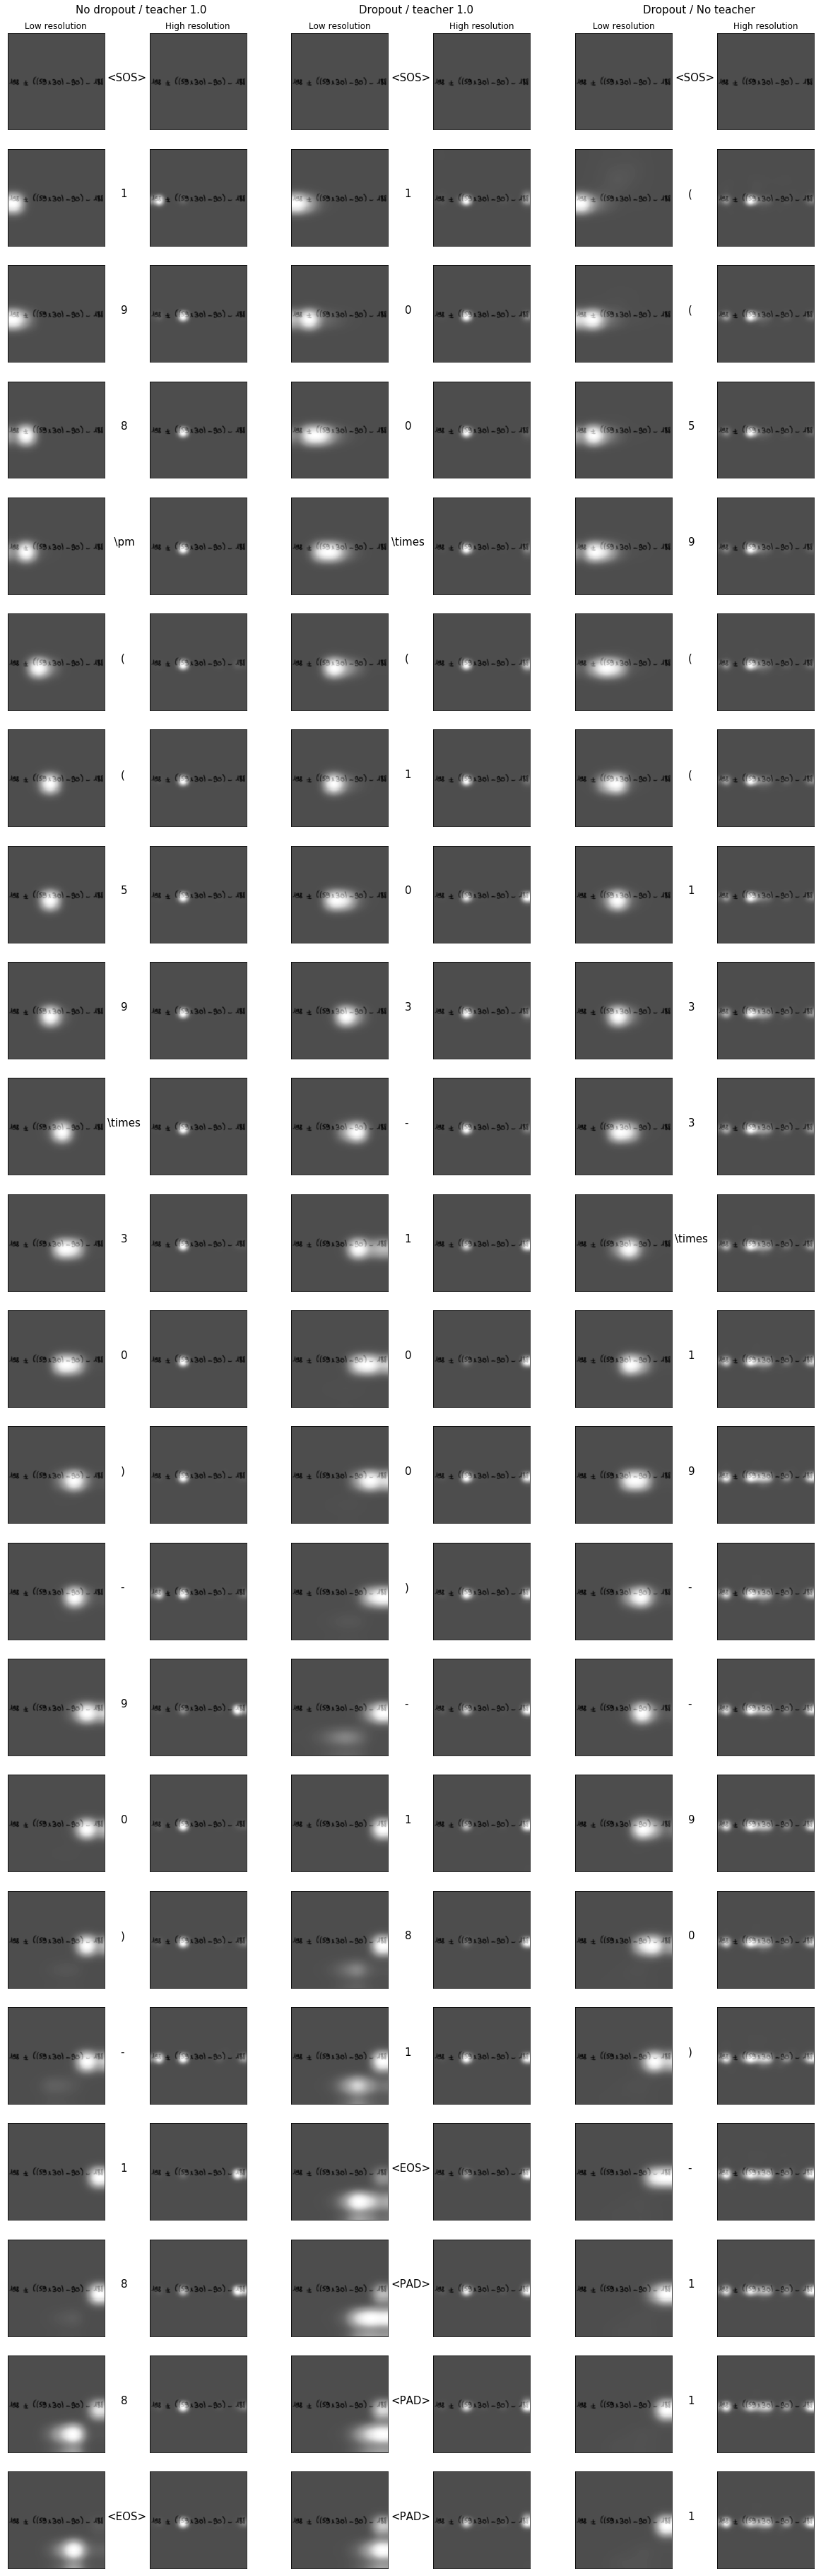

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       b`  |  `                       b`  |  `                    b`  |  `               \frac`  |
|          2  |  `       ^`  |  `                       ^`  |  `                    ^`  |  `                   {`  |
|          3  |  `       2`  |  `                       2`  |  `                    {`  |  `                   {`  |
|          4  |  `       -`  |  `                       -`  |  `                    x`  |  `                   }`  |
|          5  |  `       4`  |  `                       4`  |  `                    }`  |  `                   {`  |
|          6  |  `       a`  |  `                       a`  |  `                <EOS>`  |  `              \alpha`  |
|          7  |  `       c`  |  `                       c`  |  `                <PAD>`  |  `                   }`  |
|          8  |  `   <EOS>`  |  `                   <EOS>`  |  `                <PAD>`  |  `                   }`  |
|          9  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         10  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         11  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

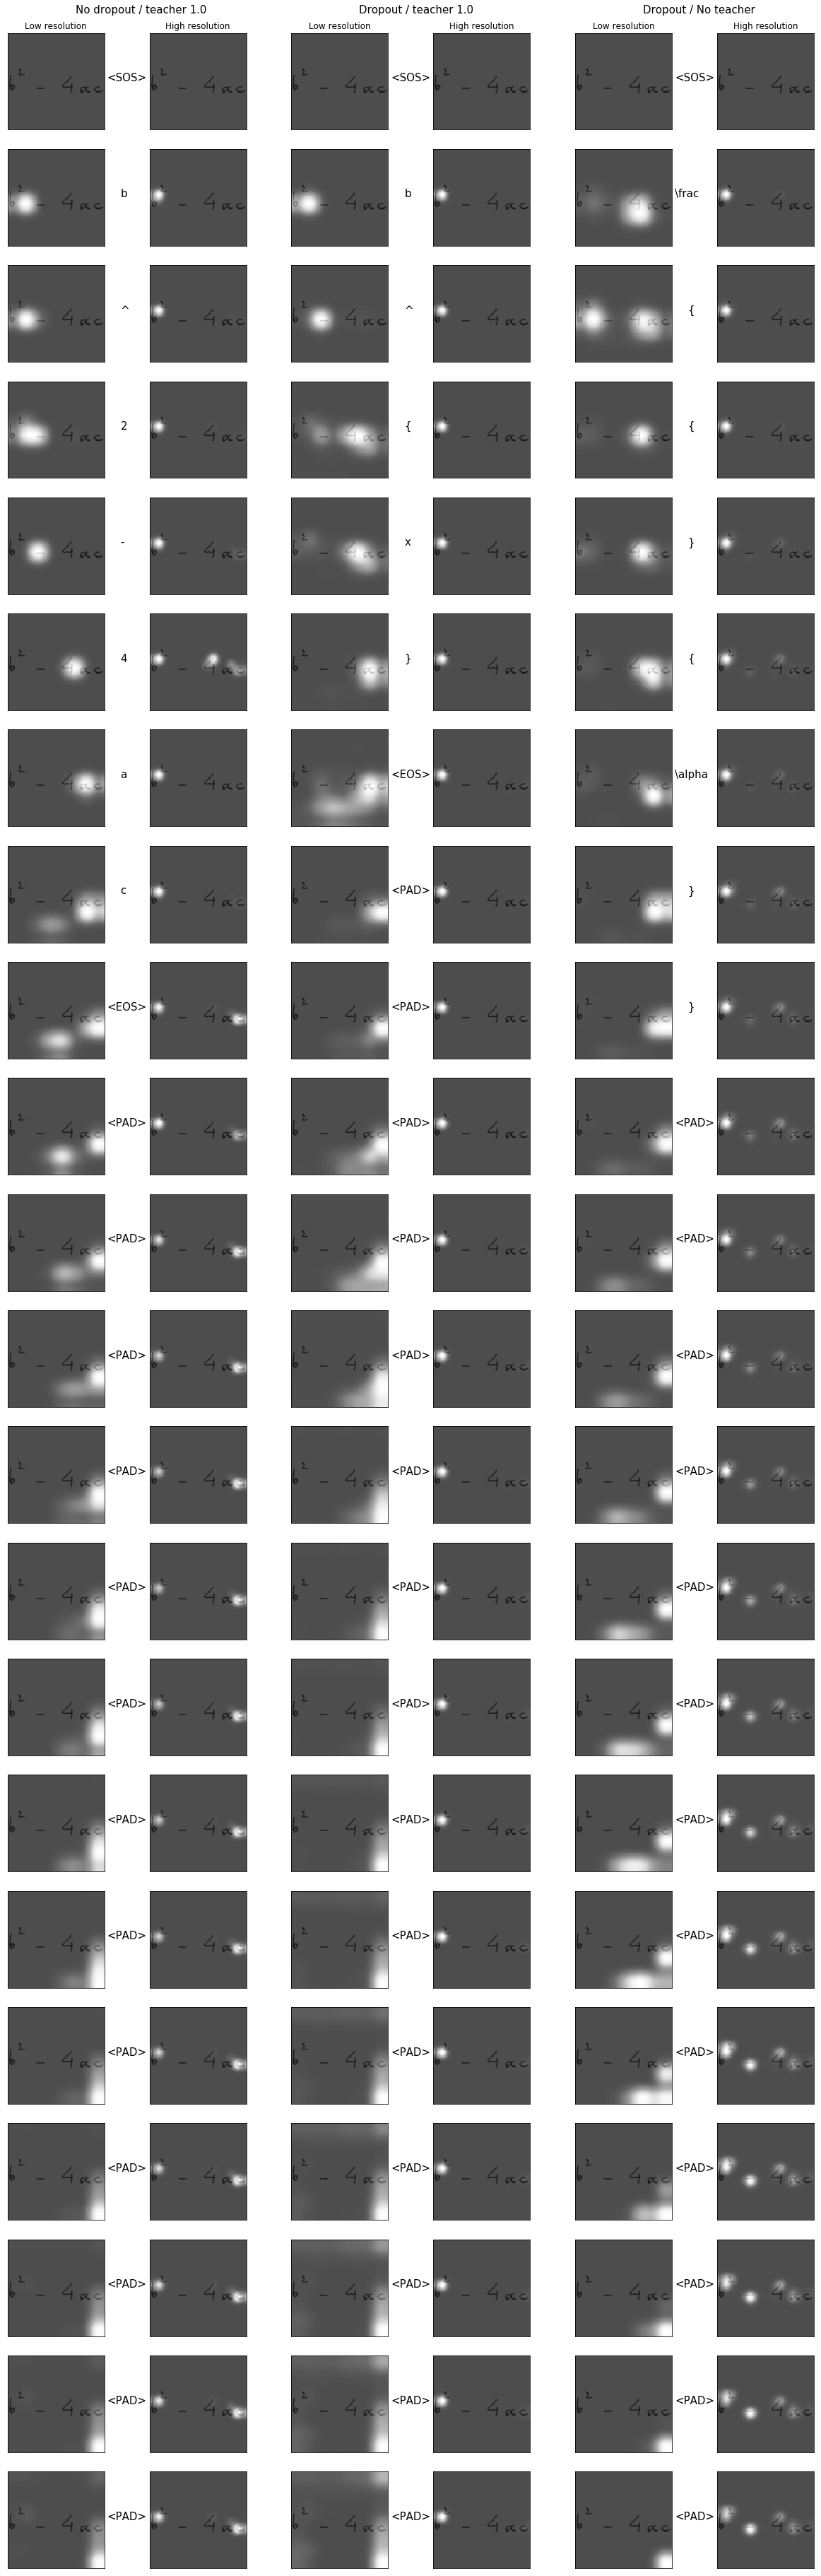

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       k`  |  `                       k`  |  `                    u`  |  `               \mbox`  |
|          2  |  `       ^`  |  `                       ^`  |  `                <EOS>`  |  `               <EOS>`  |
|          3  |  `       {`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|          4  |  `       -`  |  `                       -`  |  `                <PAD>`  |  `               <PAD>`  |
|          5  |  `       3`  |  `                       3`  |  `                <PAD>`  |  `               <PAD>`  |
|          6  |  `       }`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|          7  |  `   <EOS>`  |  `                   <EOS>`  |  `                <PAD>`  |  `               <PAD>`  |
|          8  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|          9  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         10  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         11  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

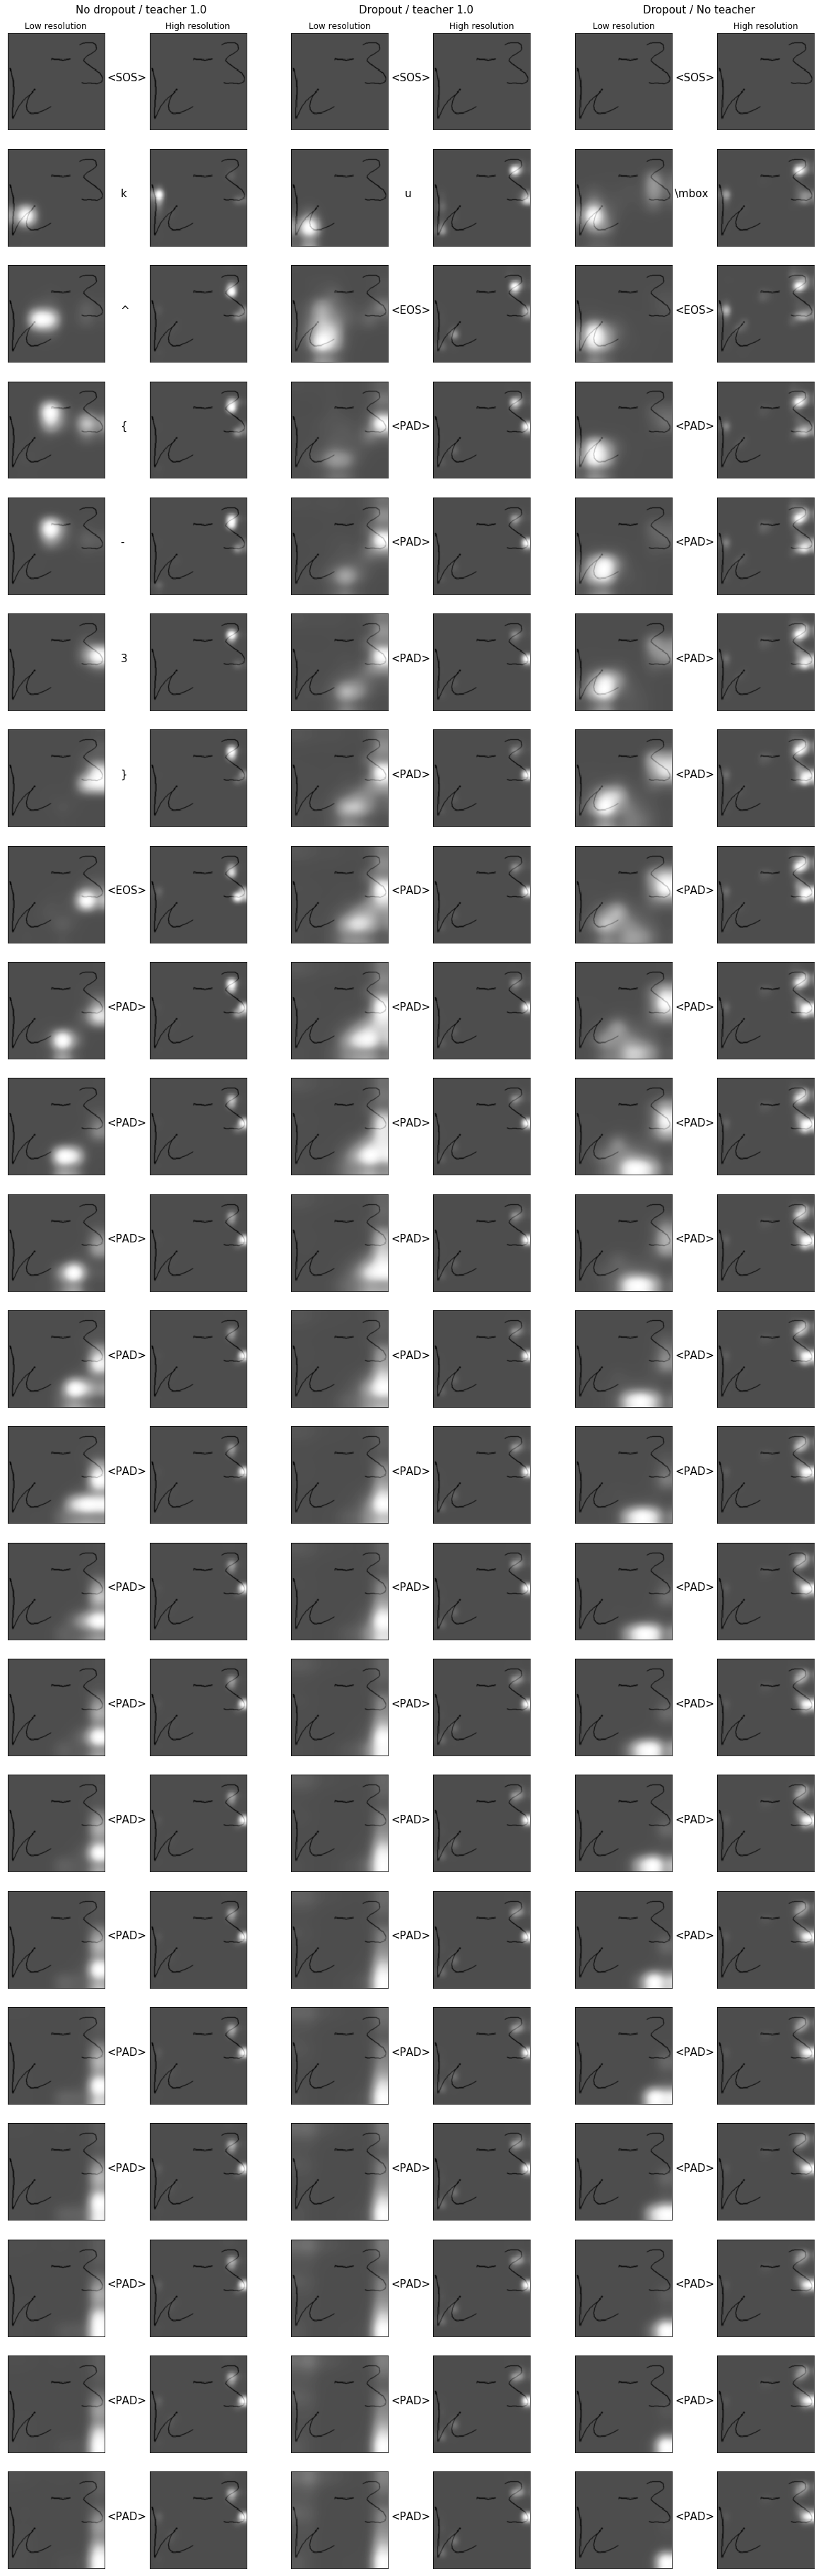

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       u`  |  `                       u`  |  `                    u`  |  `                   a`  |
|          2  |  `       _`  |  `                       _`  |  `                    0`  |  `                   _`  |
|          3  |  `       {`  |  `                       {`  |  `                <EOS>`  |  `                   {`  |
|          4  |  `       2`  |  `                       2`  |  `                <PAD>`  |  `                   0`  |
|          5  |  `       0`  |  `                       0`  |  `                <PAD>`  |  `                   }`  |
|          6  |  `       }`  |  `                       }`  |  `                <PAD>`  |  `                   }`  |
|          7  |  `   <EOS>`  |  `                   <EOS>`  |  `                <PAD>`  |  `               <EOS>`  |
|          8  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|          9  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         10  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         11  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

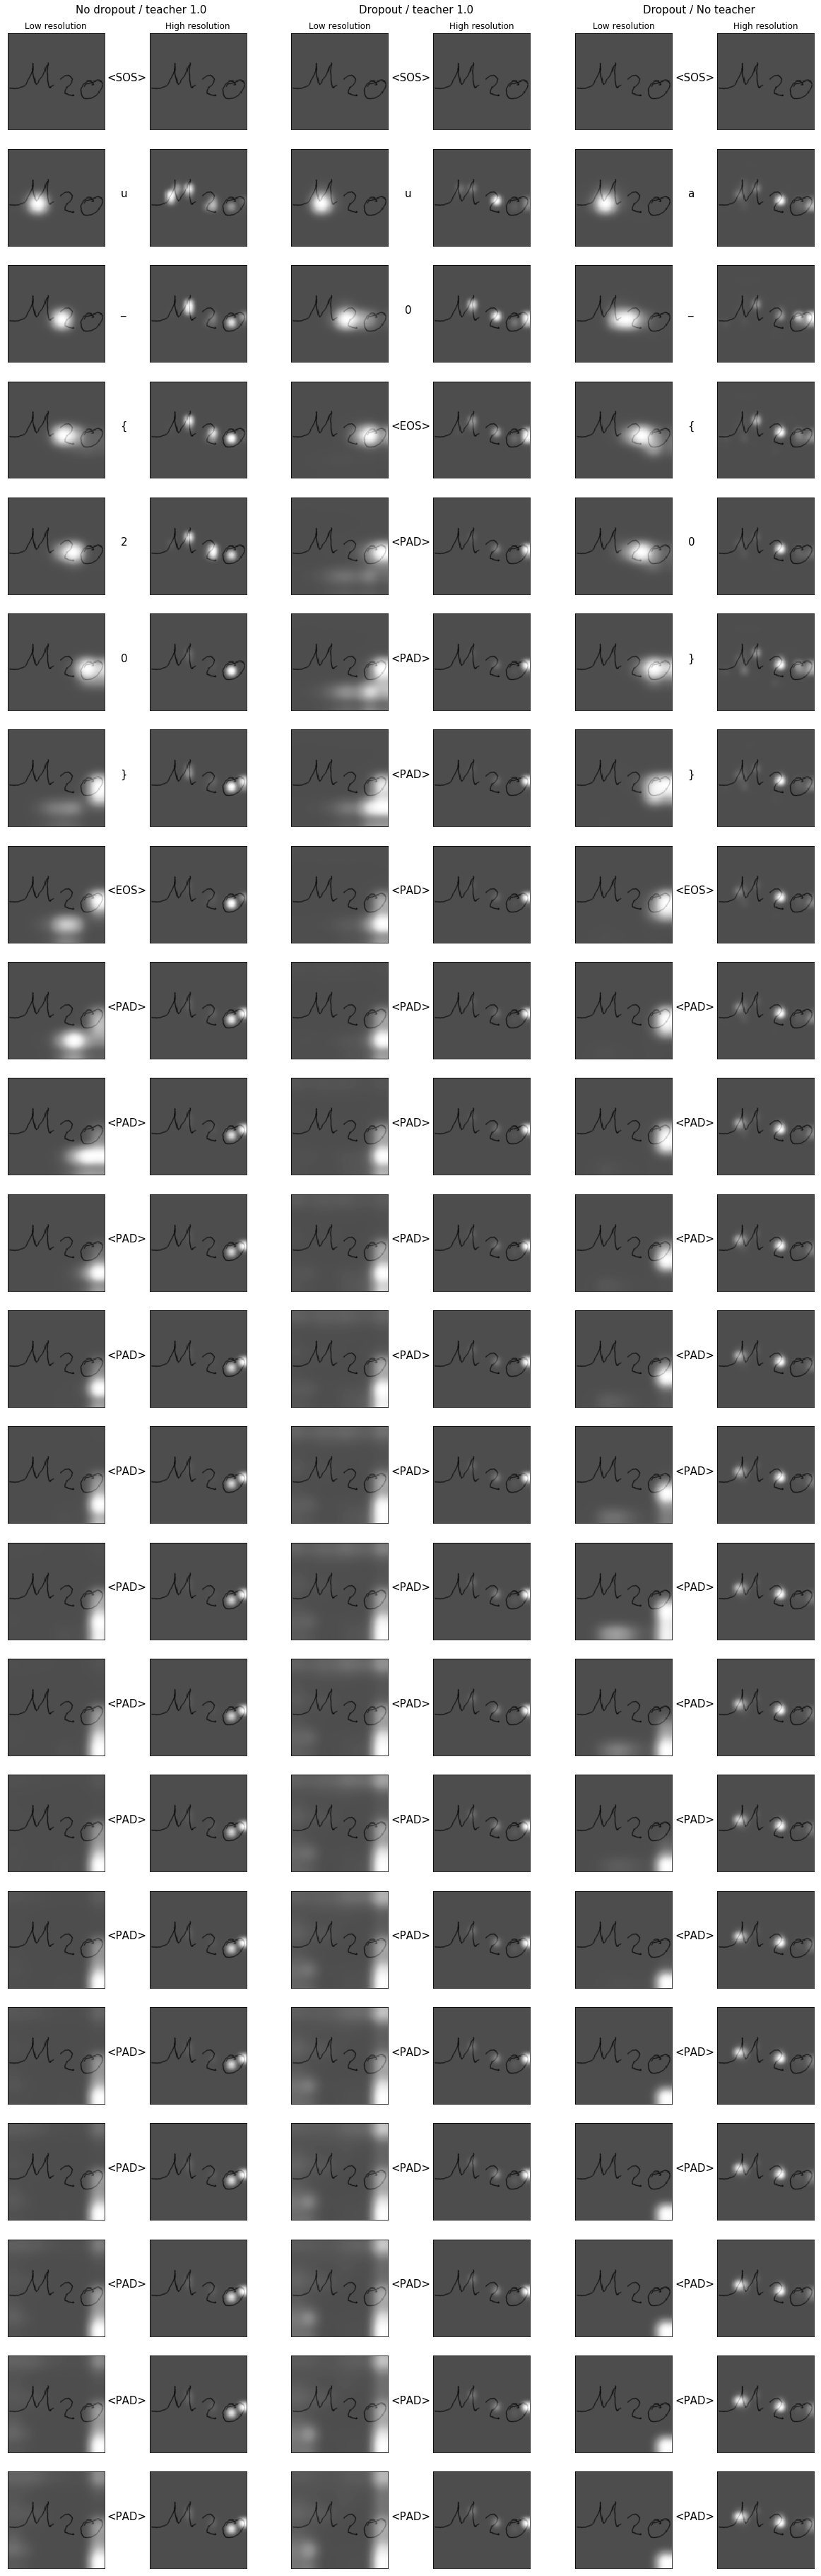

In [17]:
visualise_dataset(
    os.path.join("..", train.groundtruth),
    os.path.join("..", train.tokensfile),
    root=os.path.join("..", train.root),
)

#### Attention on test set 2013

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `   \frac`  |  `                   \frac`  |  `                \frac`  |  `                \sum`  |
|          2  |  `       {`  |  `                       {`  |  `                    {`  |  `                   {`  |
|          3  |  `       z`  |  `                       {`  |  `                    z`  |  `                   {`  |
|          4  |  `       ^`  |  `                       z`  |  `                    }`  |  `                   z`  |
|          5  |  `       {`  |  `                       ^`  |  `                    {`  |  `                   z`  |
|          6  |  `       3`  |  `                       {`  |  `                    3`  |  `                   }`  |
|          7  |  `       }`  |  `                       3`  |  `                    }`  |  `                   z`  |
|          8  |  `       -`  |  `                       }`  |  `                <EOS>`  |  `                   }`  |
|          9  |  `       2`  |  `                       }`  |  `                <PAD>`  |  `                   }`  |
|         10  |  `       z`  |  `                       {`  |  `                <PAD>`  |  `                   }`  |
|         11  |  `       +`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `       1`  |  `                       z`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `       }`  |  `                       ^`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `       {`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `       z`  |  `                       3`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `       ^`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `       {`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `       5`  |  `                       +`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `       }`  |  `                       3`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `       +`  |  `                       z`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `       3`  |  `                       ^`  |  `                <PAD>`  |  `               <PAD>`  |
|         22  |  `       z`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         23  |  `       -`  |  `                       2`  |  `                <PAD>`  |  `               <PAD>`  |
|         24  |  `       1`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         25  |  `       }`  |  `                       +`  |  `                <PAD>`  |  `               <PAD>`  |
|         26  |  `   <EOS>`  |  `                       3`  |  `                <PAD>`  |  `               <PAD>`  |

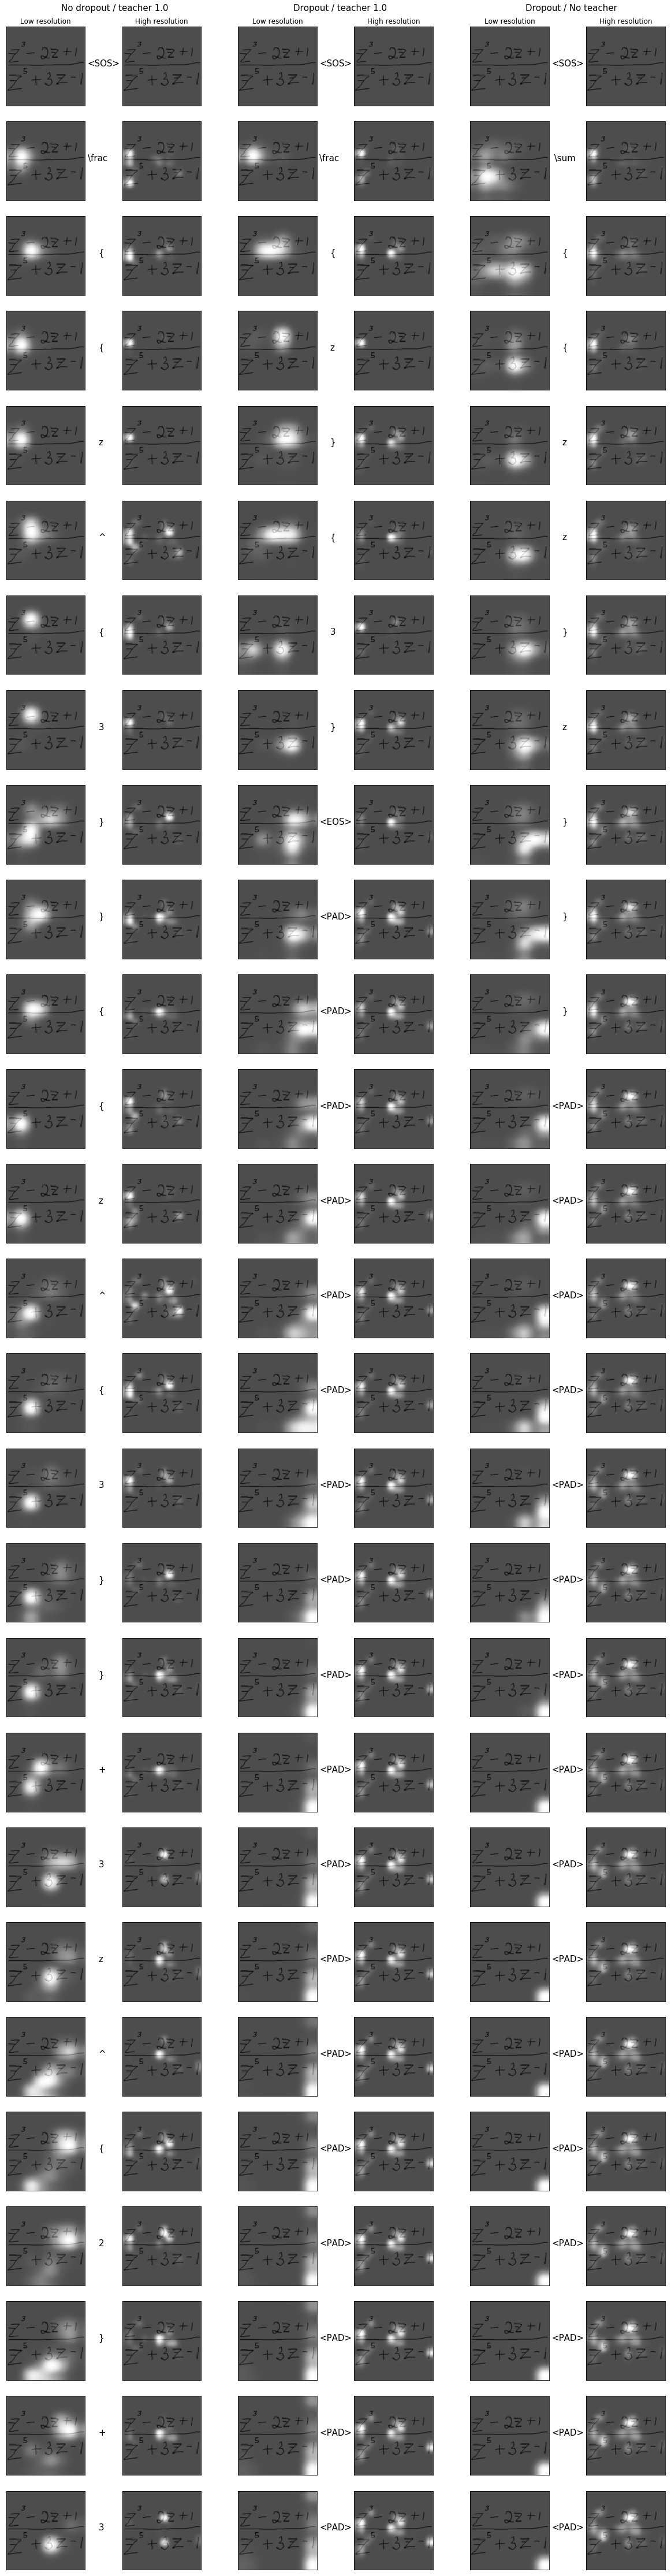

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `     \mu`  |  `                       {`  |  `                    a`  |  `               \sqrt`  |
|          2  |  `       e`  |  `                       {`  |  `                    c`  |  `                   {`  |
|          3  |  `   \frac`  |  `                       t`  |  `                    =`  |  `               \sqrt`  |
|          4  |  `       {`  |  `                       }`  |  `                    a`  |  `                   {`  |
|          5  |  `       N`  |  `                       ^`  |  `                <EOS>`  |  `                   x`  |
|          6  |  `       }`  |  `                       {`  |  `                <PAD>`  |  `                   }`  |
|          7  |  `       {`  |  `                   \frac`  |  `                <PAD>`  |  `                   {`  |
|          8  |  `       L`  |  `                       {`  |  `                <PAD>`  |  `                   {`  |
|          9  |  `       ^`  |  `                       N`  |  `                <PAD>`  |  `                   }`  |
|         10  |  `       2`  |  `                       }`  |  `                <PAD>`  |  `                   }`  |
|         11  |  `       }`  |  `                       {`  |  `                <PAD>`  |  `                   }`  |
|         12  |  `       =`  |  `                   \mbox`  |  `                <PAD>`  |  `                   }`  |
|         13  |  `       R`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `       ^`  |  `                       c`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `       {`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `       -`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `       1`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `       }`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `   <EOS>`  |  `                   \mbox`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `   <PAD>`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `   <PAD>`  |  `                       z`  |  `                <PAD>`  |  `               <PAD>`  |
|         22  |  `   <PAD>`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         23  |  `   <PAD>`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         24  |  `   <PAD>`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         25  |  `   <PAD>`  |  `                       =`  |  `                <PAD>`  |  `               <PAD>`  |
|         26  |  `   <PAD>`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |

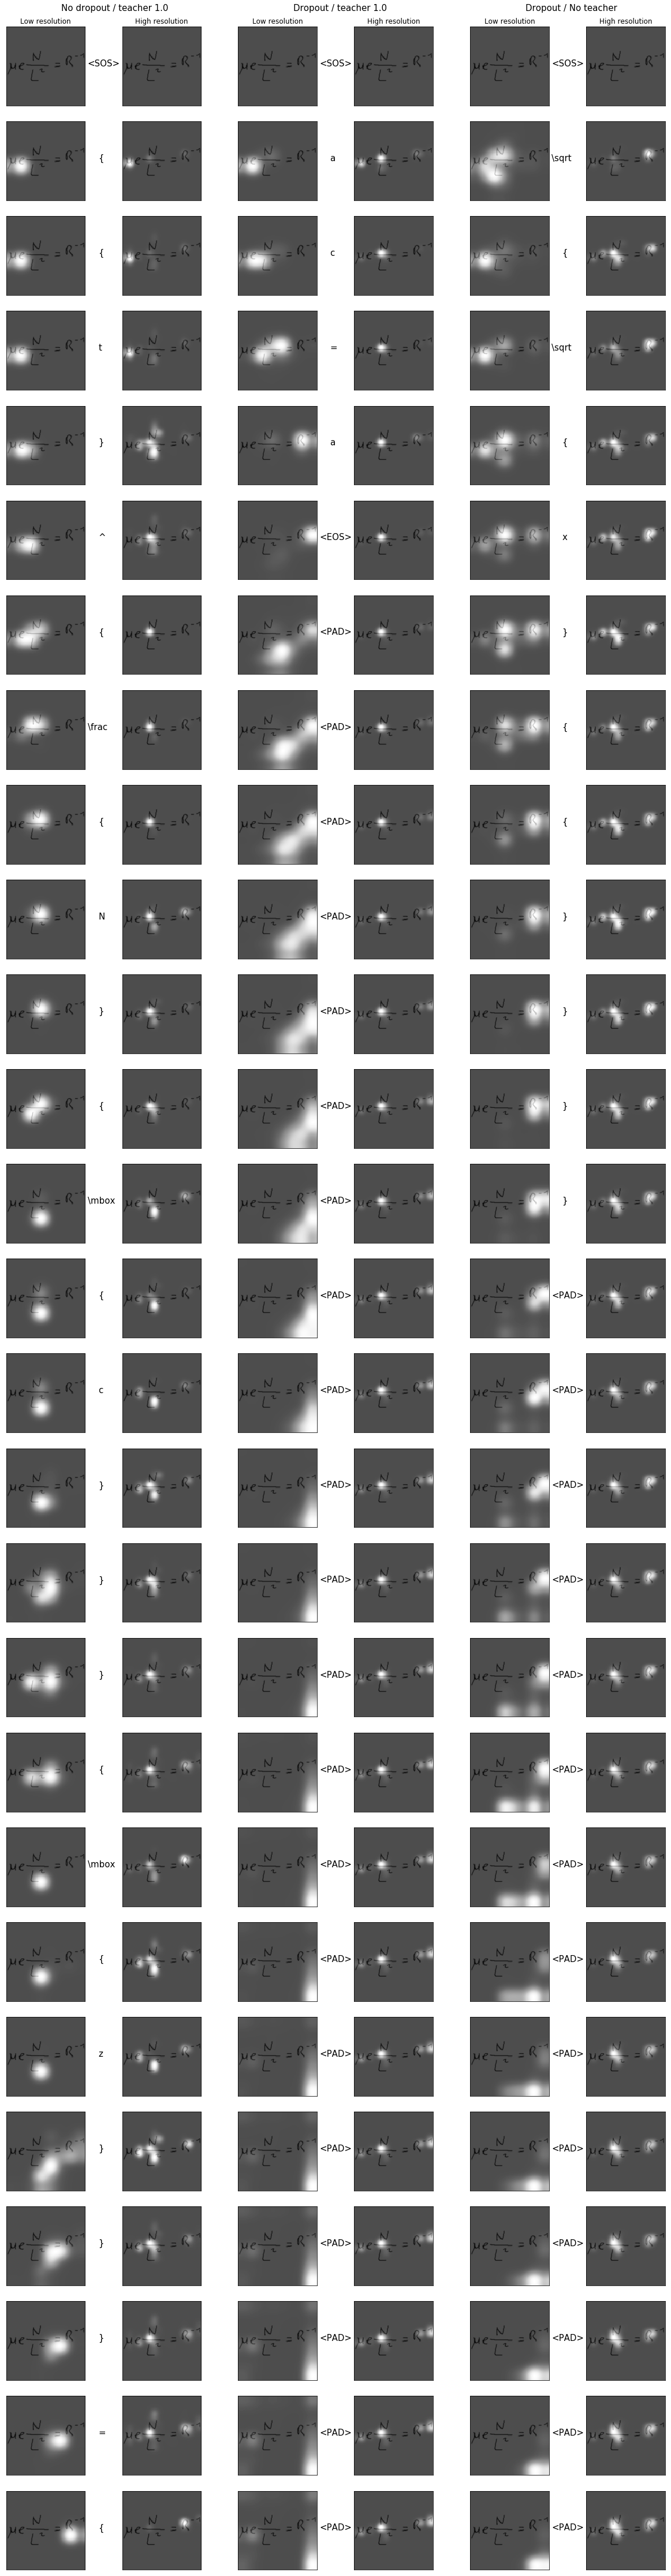

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       H`  |  `                       H`  |  `                    1`  |  `              \theta`  |
|          2  |  `       S`  |  `                       s`  |  `                    3`  |  `               <EOS>`  |
|          3  |  `       _`  |  `                       _`  |  `                    0`  |  `                   {`  |
|          4  |  `       2`  |  `                       {`  |  `                <EOS>`  |  `               \mbox`  |
|          5  |  `   <EOS>`  |  `                   \mbox`  |  `                <PAD>`  |  `                   {`  |
|          6  |  `   <PAD>`  |  `                       {`  |  `                <PAD>`  |  `                   }`  |
|          7  |  `   <PAD>`  |  `                       S`  |  `                <PAD>`  |  `                   }`  |
|          8  |  `   <PAD>`  |  `                       }`  |  `                <PAD>`  |  `                   }`  |
|          9  |  `   <PAD>`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         10  |  `   <PAD>`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         11  |  `   <PAD>`  |  `                   <EOS>`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         22  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         23  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         24  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         25  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         26  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

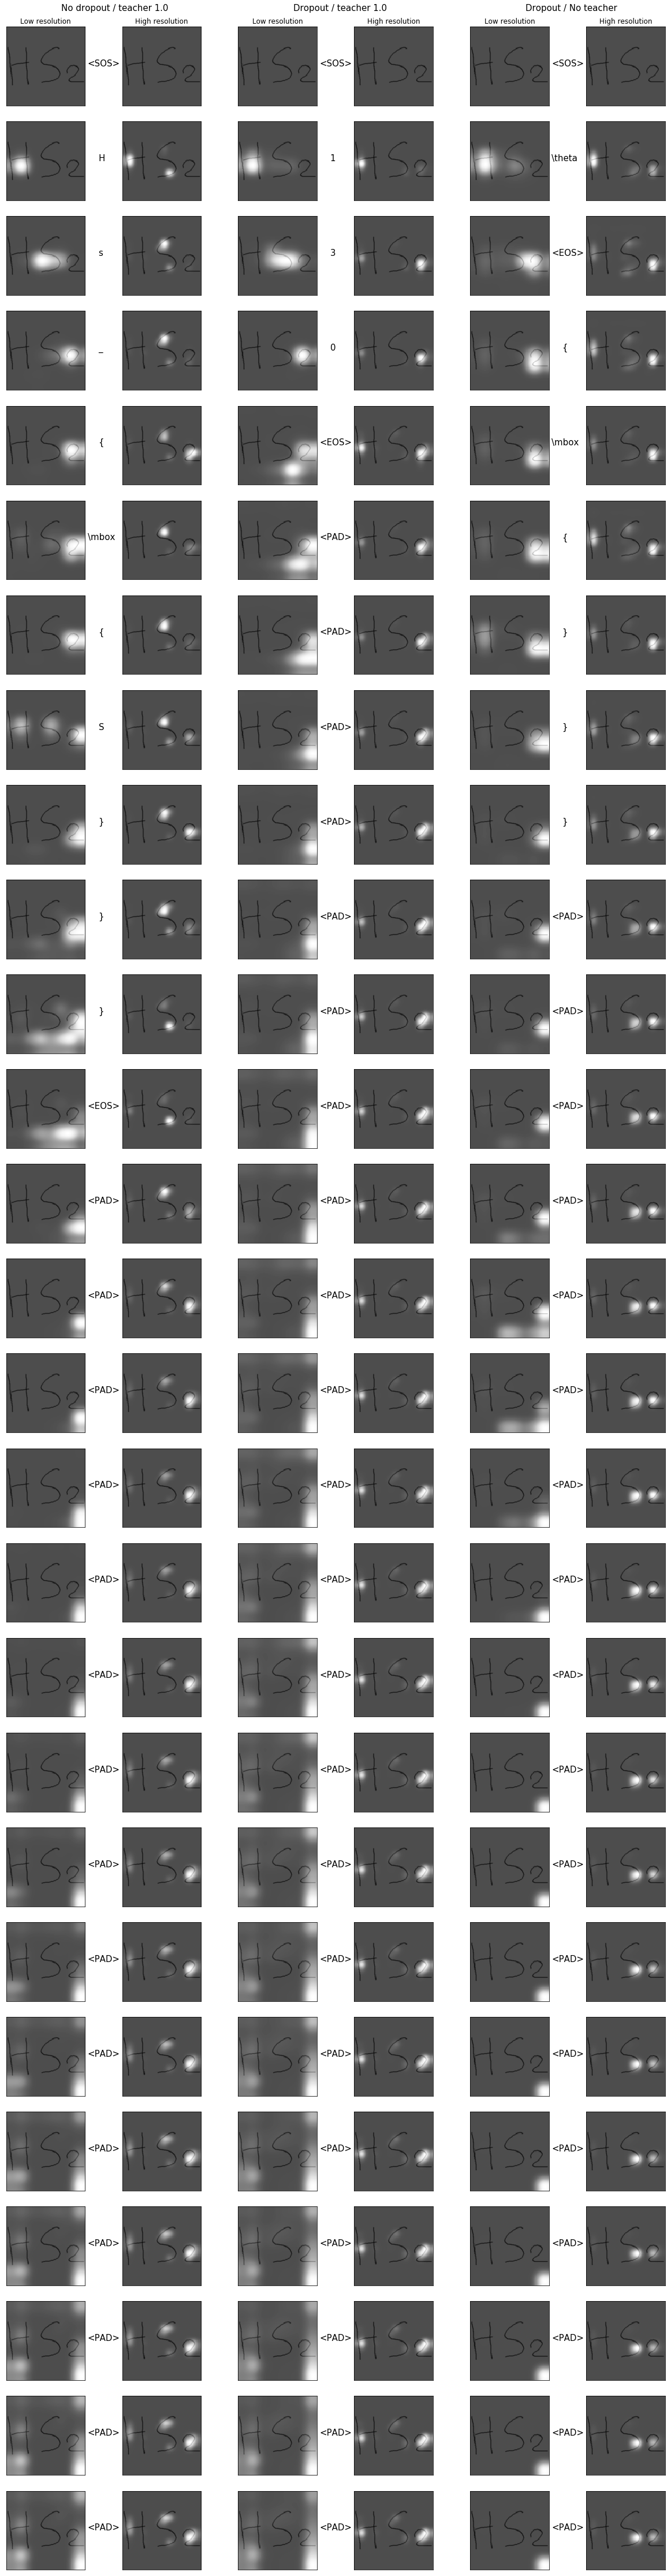

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       u`  |  `                       u`  |  `                    u`  |  `                   a`  |
|          2  |  `       _`  |  `                       _`  |  `                    _`  |  `                   _`  |
|          3  |  `       n`  |  `                       u`  |  `                    n`  |  `                   {`  |
|          4  |  `       =`  |  `                       _`  |  `                    =`  |  `                   {`  |
|          5  |  `       o`  |  `                       n`  |  `                    (`  |  `                   }`  |
|          6  |  `       (`  |  `                       =`  |  `                    x`  |  `               \sqrt`  |
|          7  |  `       v`  |  `                       c`  |  `                    )`  |  `               \sqrt`  |
|          8  |  `       _`  |  `                       (`  |  `                <EOS>`  |  `                   }`  |
|          9  |  `       n`  |  `                       u`  |  `                <PAD>`  |  `                   }`  |
|         10  |  `       )`  |  `                       _`  |  `                <PAD>`  |  `                   }`  |
|         11  |  `   <EOS>`  |  `                       n`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `   <PAD>`  |  `                       )`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `   <PAD>`  |  `                   <EOS>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         16  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         17  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         18  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         19  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         20  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         21  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         22  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         23  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         24  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         25  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         26  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

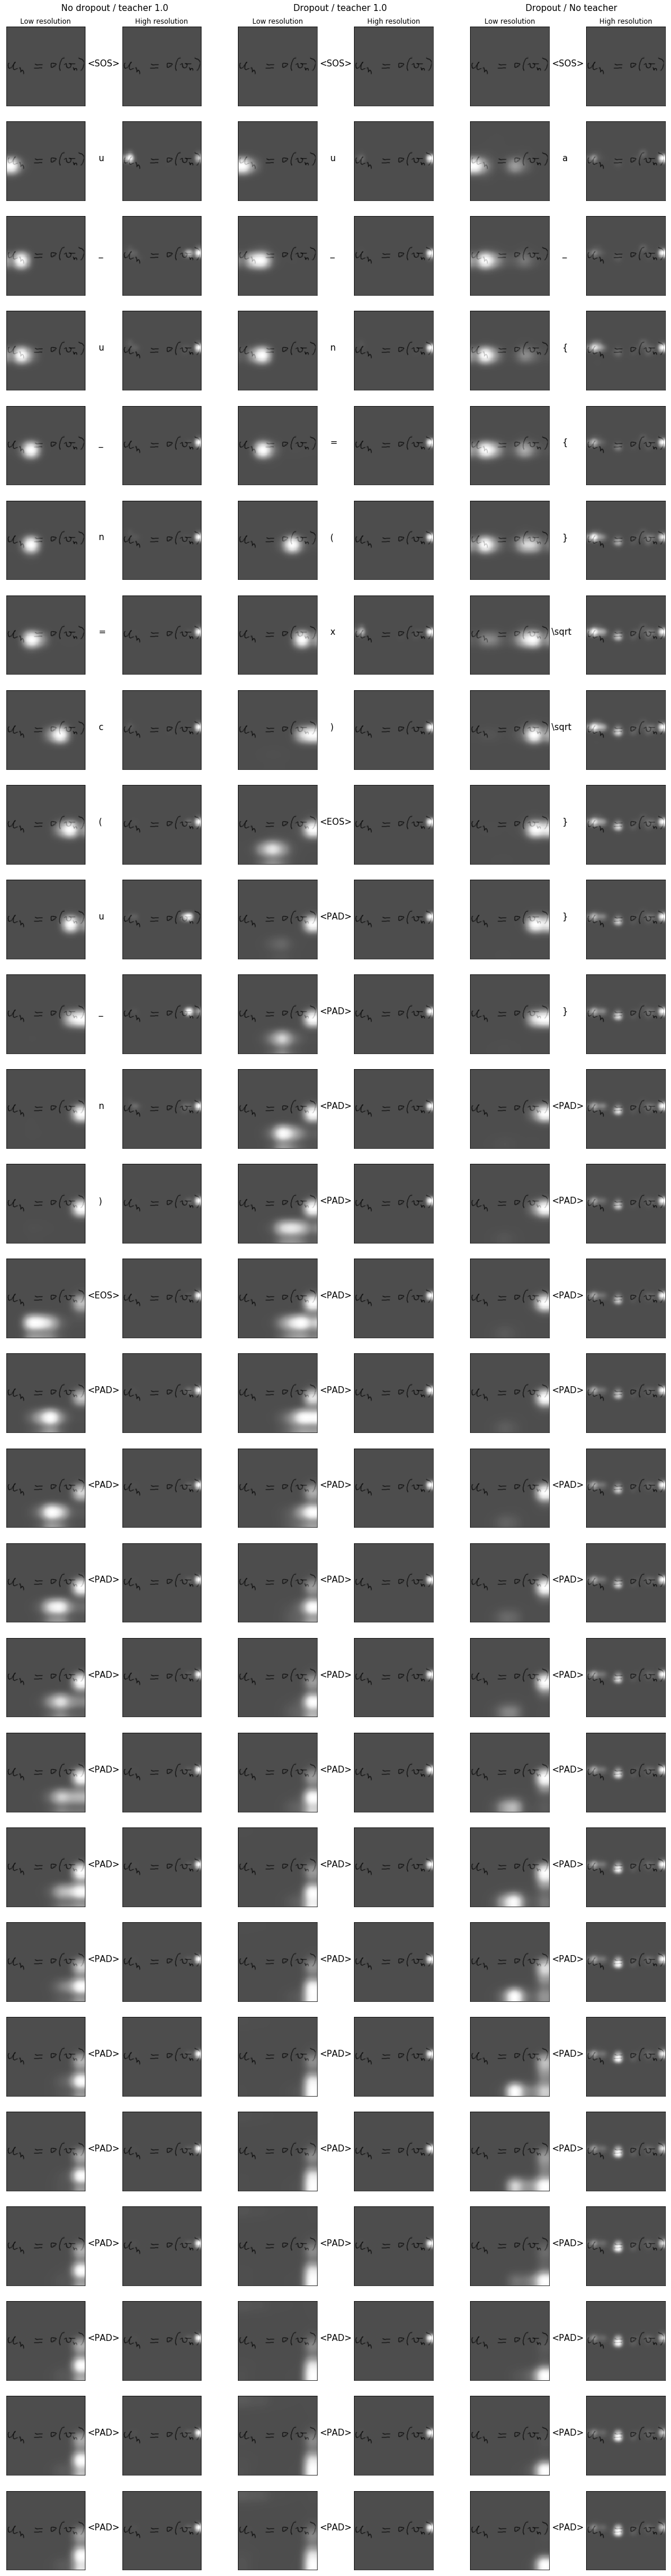

In [18]:
visualise_dataset(
    os.path.join("..", evaluate.test_sets["2013"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2013"]["root"]),
)

#### Attention on test set 2016

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `   \frac`  |  `                   \frac`  |  `                \frac`  |  `               \frac`  |
|          2  |  `       {`  |  `                       {`  |  `                    {`  |  `                   {`  |
|          3  |  `       9`  |  `                       {`  |  `                    4`  |  `               \mbox`  |
|          4  |  `       -`  |  `                       q`  |  `                    5`  |  `                   {`  |
|          5  |  `       4`  |  `                       -`  |  `                    }`  |  `               \sqrt`  |
|          6  |  `   \sqrt`  |  `                       4`  |  `                    }`  |  `                   {`  |
|          7  |  `       {`  |  `                   \sqrt`  |  `                    {`  |  `                   }`  |
|          8  |  `       3`  |  `                       {`  |  `                    3`  |  `                   }`  |
|          9  |  `       }`  |  `                       5`  |  `                    }`  |  `                   }`  |
|         10  |  `       }`  |  `                       }`  |  `                <EOS>`  |  `               <EOS>`  |
|         11  |  `       {`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `       3`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `       3`  |  `                       {`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `       }`  |  `                       3`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <EOS>`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |

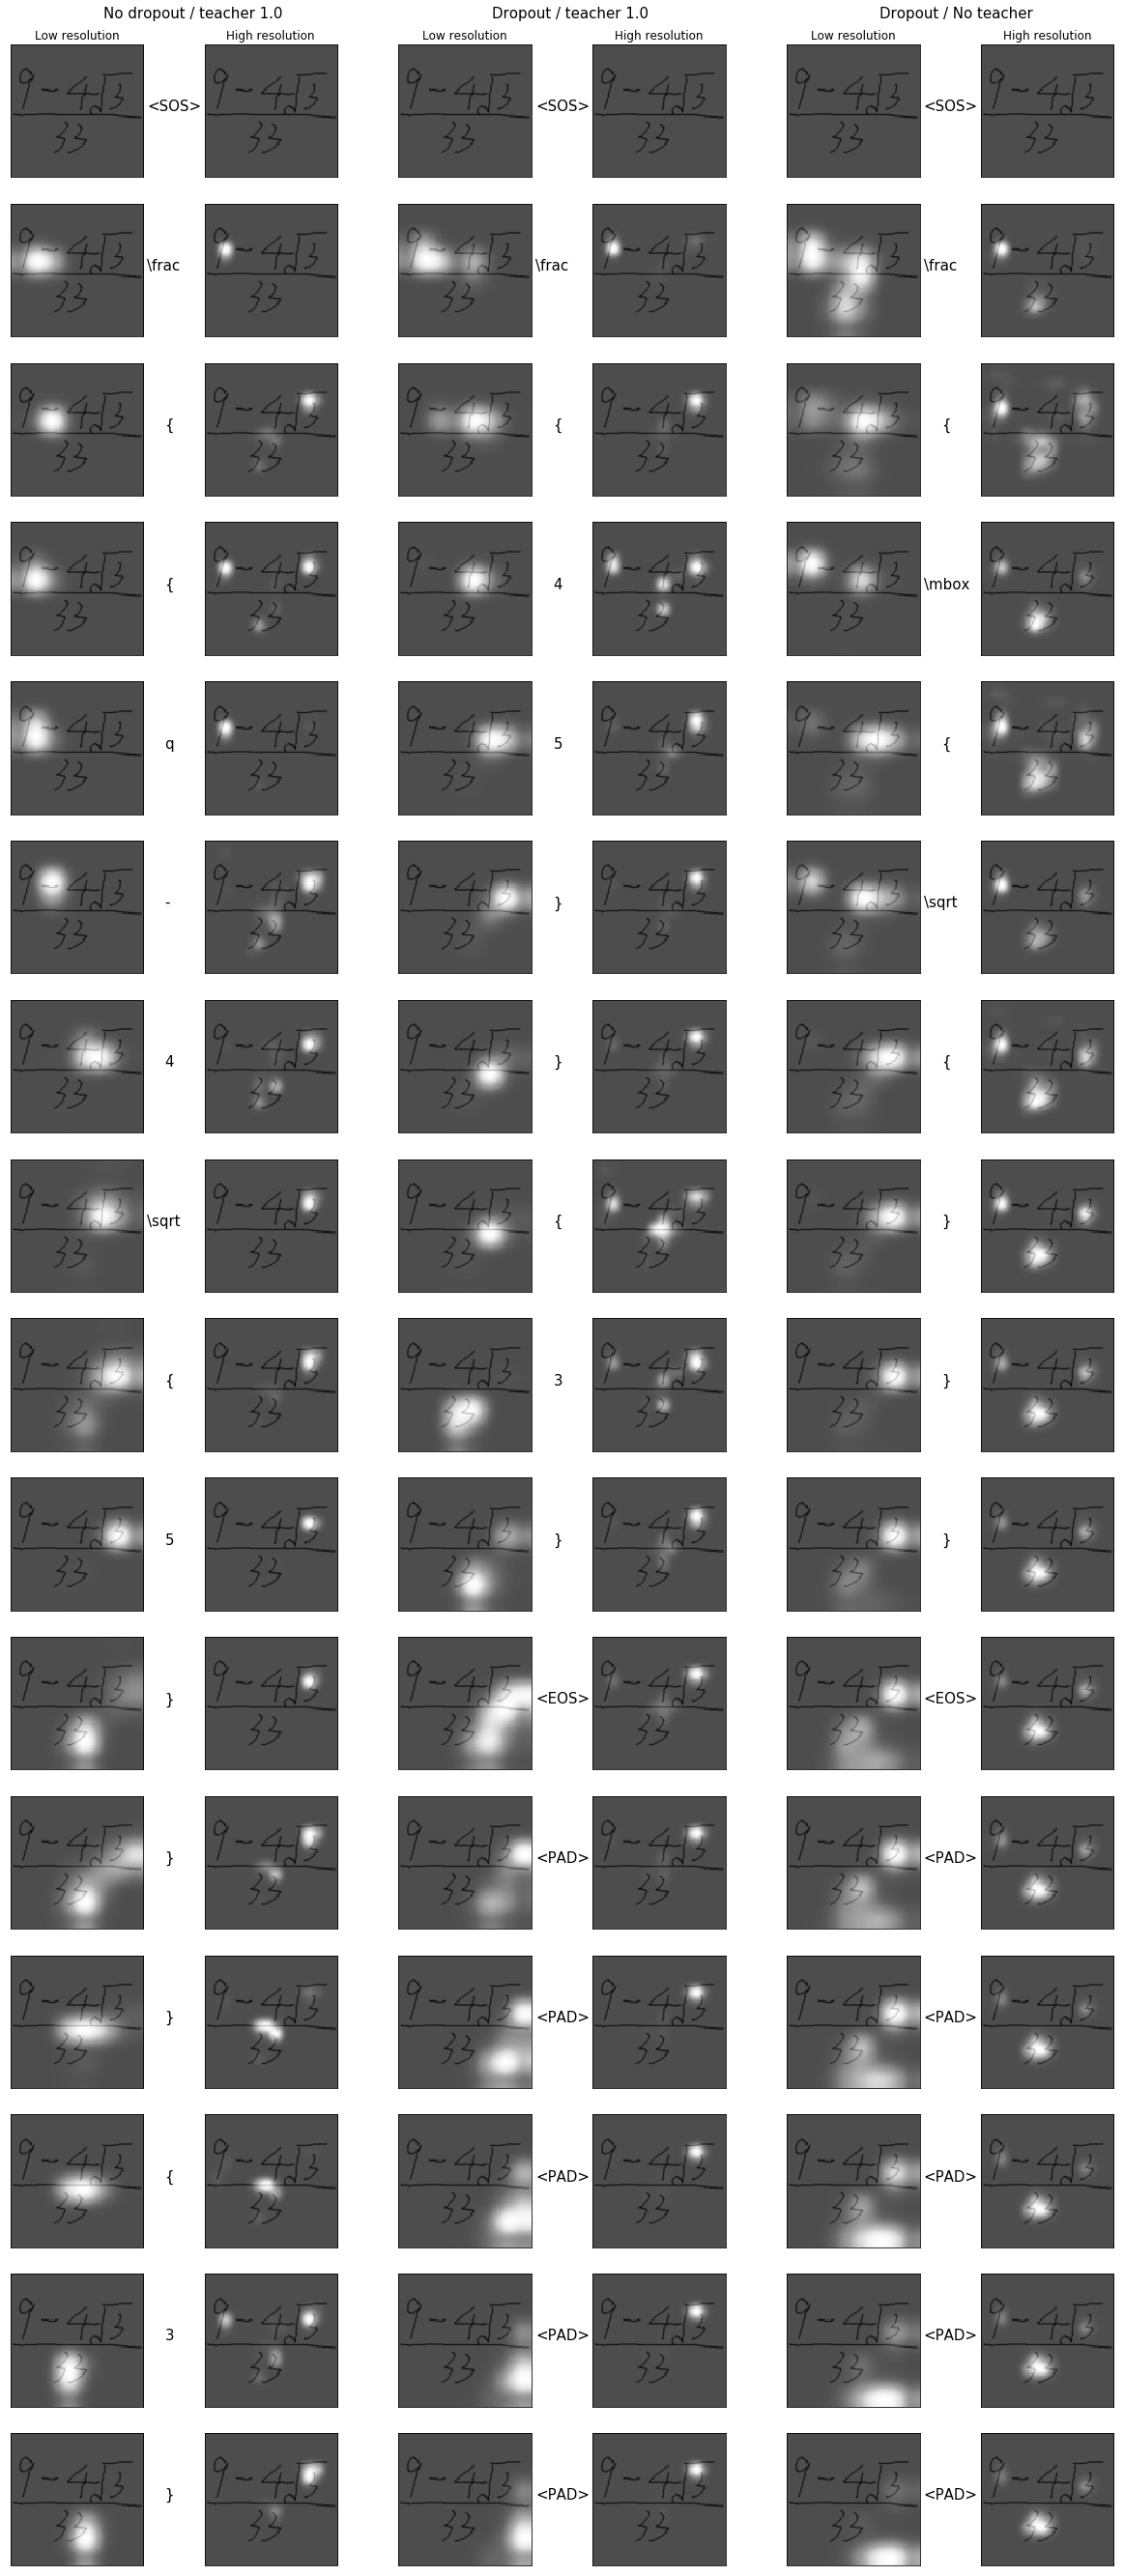

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       x`  |  `                       x`  |  `                    x`  |  `               \sqrt`  |
|          2  |  `       ^`  |  `                       ^`  |  `                    ^`  |  `                   {`  |
|          3  |  `       n`  |  `                       {`  |  `                    {`  |  `                   x`  |
|          4  |  `       +`  |  `                       2`  |  `                    n`  |  `                   ^`  |
|          5  |  `       y`  |  `                       }`  |  `                    -`  |  `                   {`  |
|          6  |  `       ^`  |  `                       +`  |  `                    2`  |  `                   2`  |
|          7  |  `       n`  |  `                       y`  |  `                    }`  |  `                   }`  |
|          8  |  `       +`  |  `                       ^`  |  `                    =`  |  `                   }`  |
|          9  |  `       z`  |  `                       {`  |  `                    0`  |  `                   }`  |
|         10  |  `       ^`  |  `                       n`  |  `                <EOS>`  |  `               <EOS>`  |
|         11  |  `       n`  |  `                       +`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `       =`  |  `                       2`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `       0`  |  `                       }`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <EOS>`  |  `                       =`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                       0`  |  `                <PAD>`  |  `               <PAD>`  |

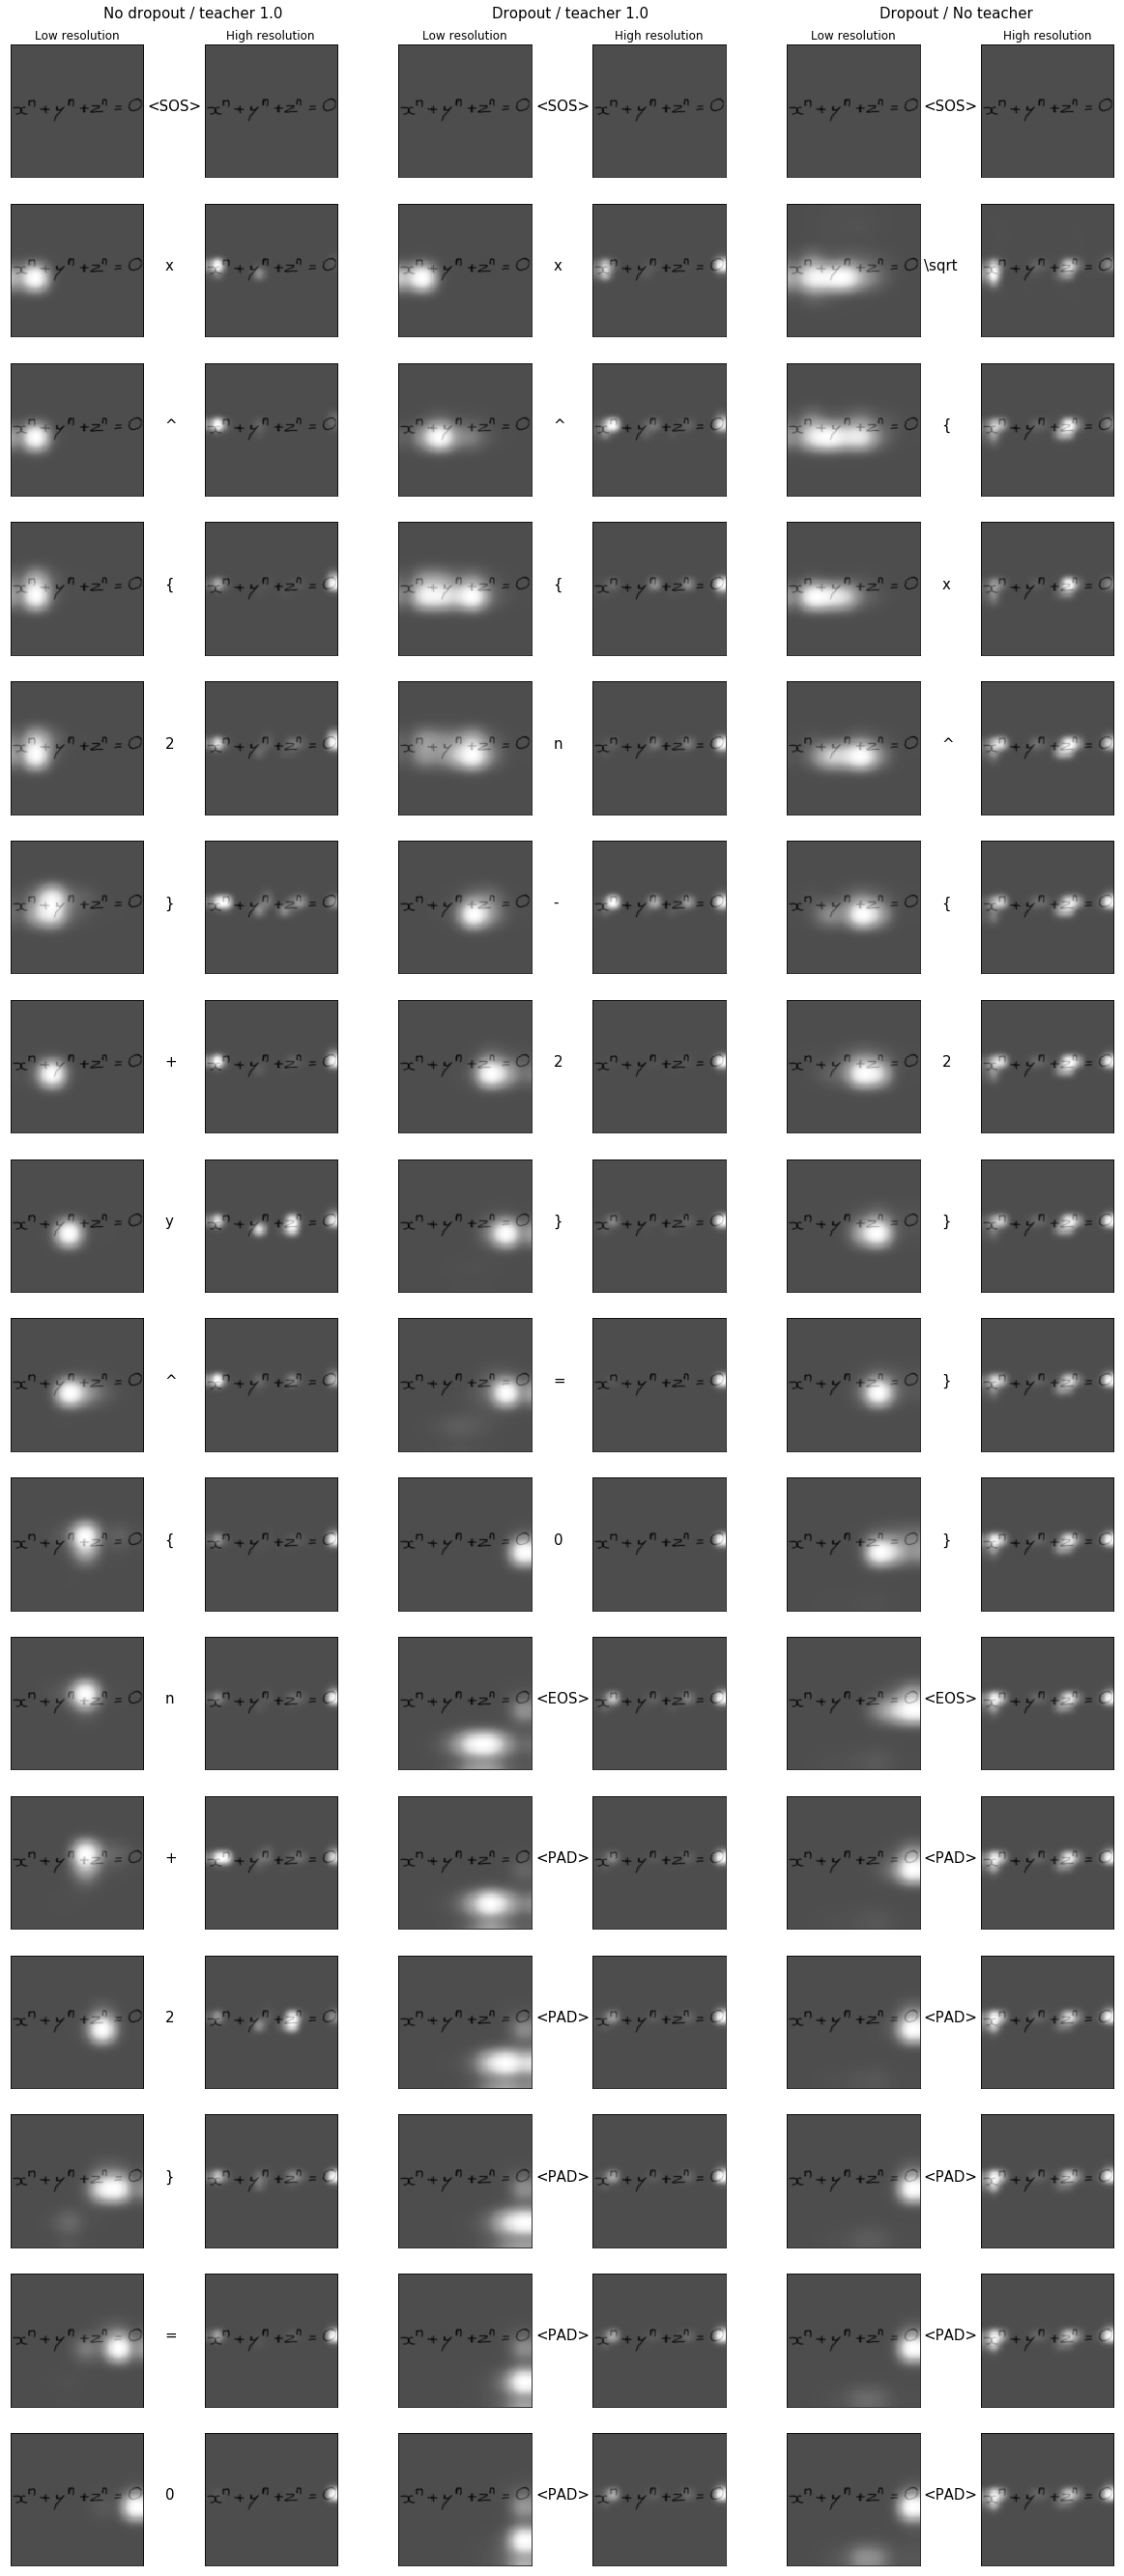

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `       x`  |  `                       x`  |  `                    x`  |  `               \sqrt`  |
|          2  |  `       _`  |  `                       _`  |  `               \times`  |  `                   {`  |
|          3  |  `       1`  |  `                       1`  |  `                    x`  |  `                   x`  |
|          4  |  `       +`  |  `                  \times`  |  `                    0`  |  `                   }`  |
|          5  |  `       x`  |  `                       x`  |  `                <EOS>`  |  `                   {`  |
|          6  |  `       _`  |  `                       _`  |  `                <PAD>`  |  `                   x`  |
|          7  |  `       2`  |  `                       0`  |  `                <PAD>`  |  `                   }`  |
|          8  |  `       +`  |  `                       +`  |  `                <PAD>`  |  `               <EOS>`  |
|          9  |  `       x`  |  `                       x`  |  `                <PAD>`  |  `               <PAD>`  |
|         10  |  `       _`  |  `                       =`  |  `                <PAD>`  |  `               <PAD>`  |
|         11  |  `       3`  |  `                       0`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `       =`  |  `                   <EOS>`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `       0`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <EOS>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

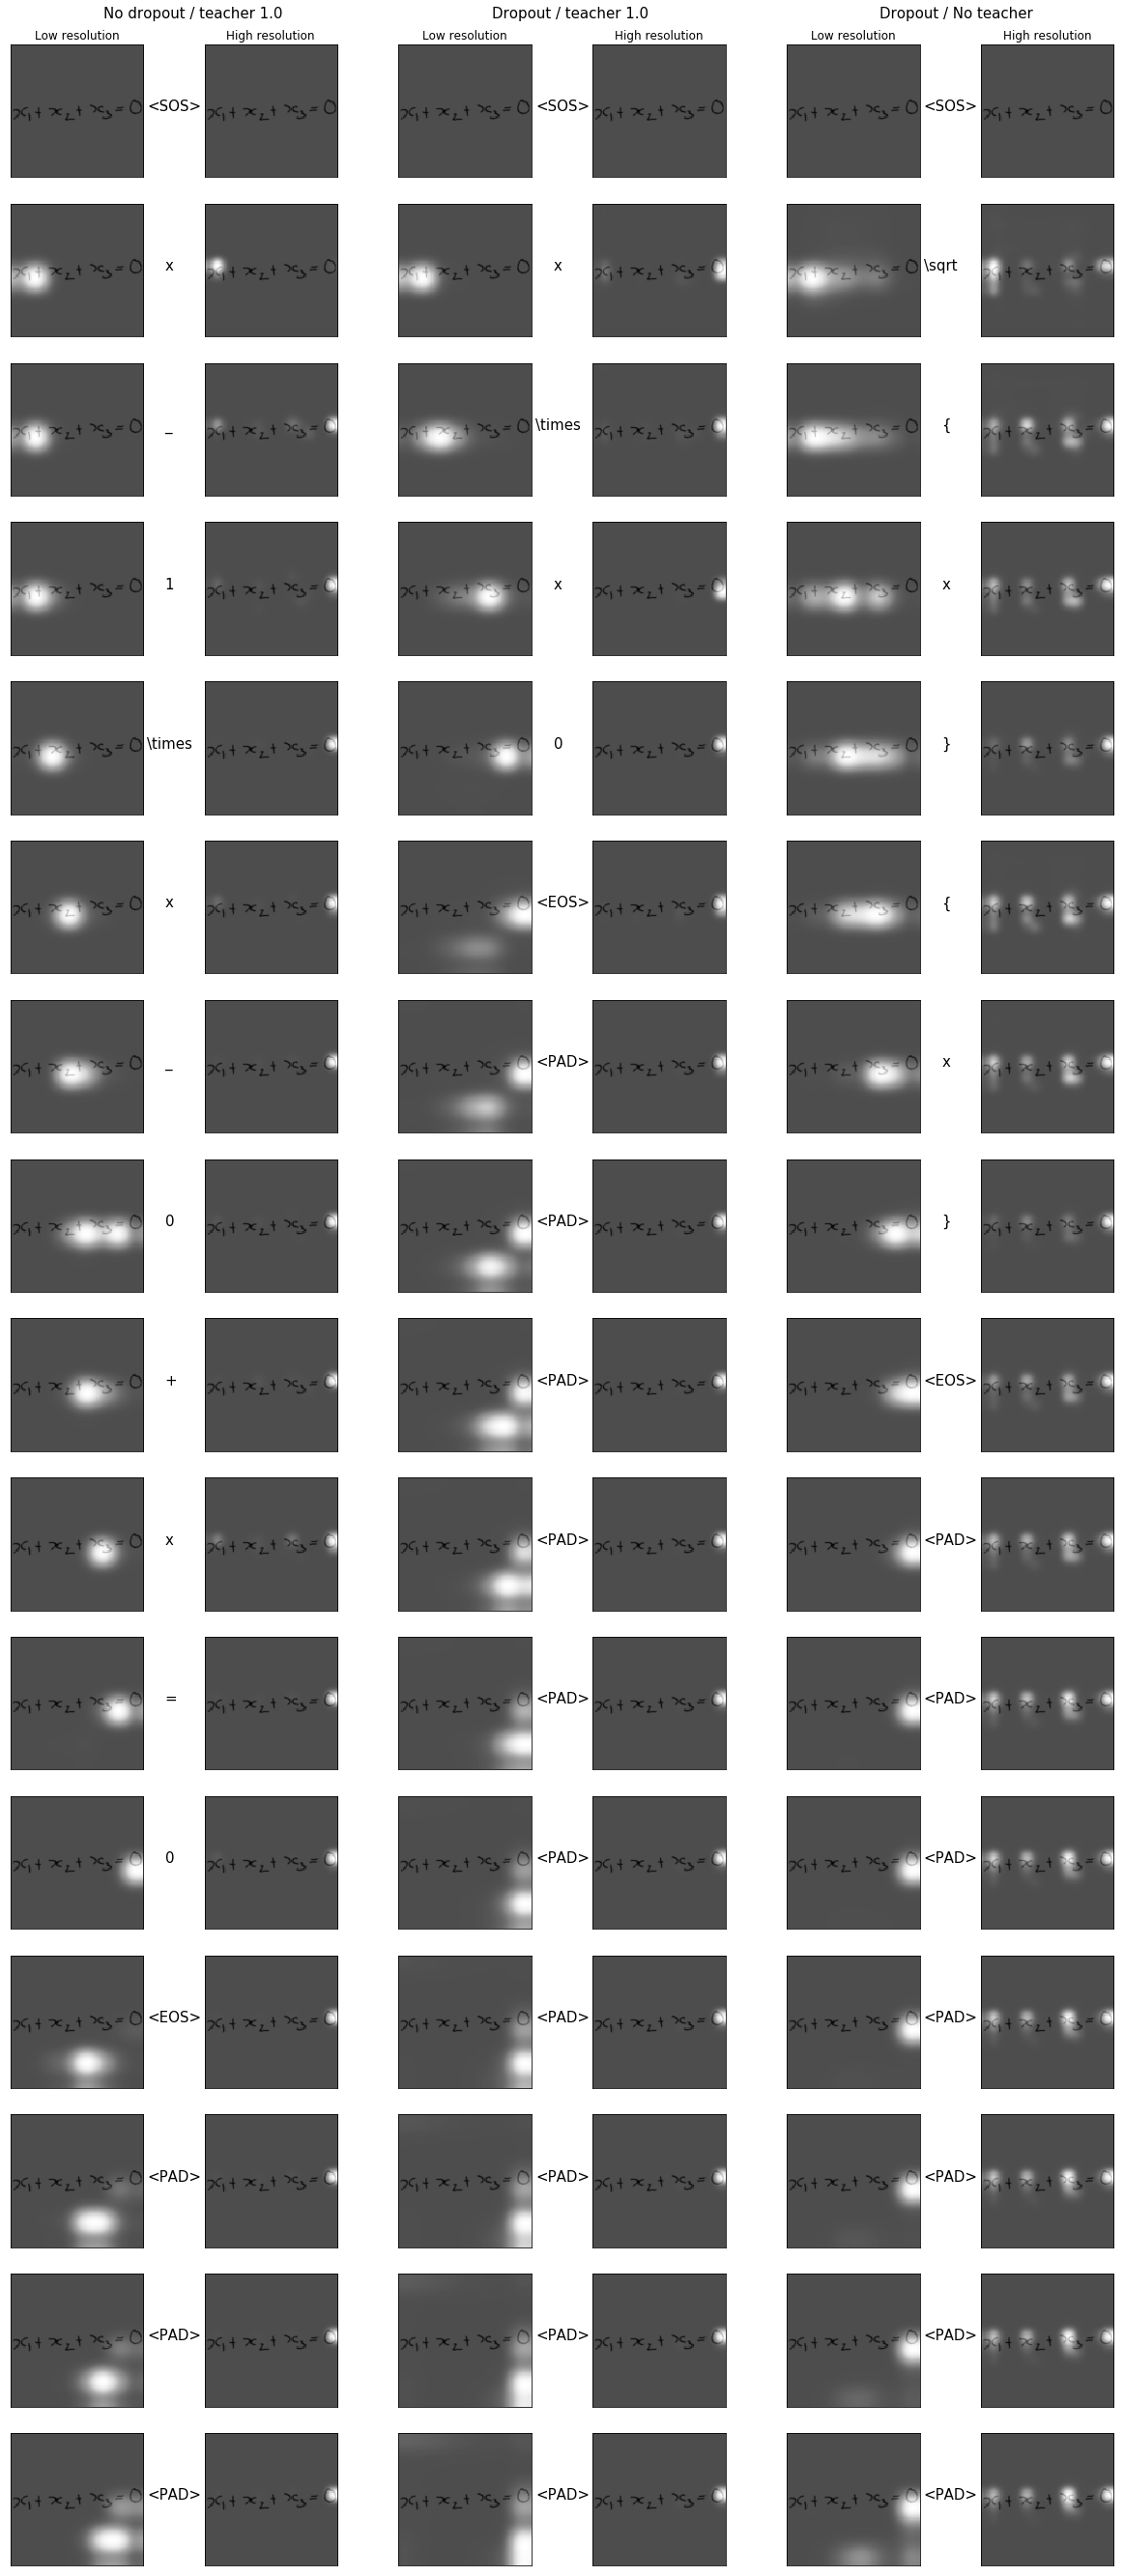

|  Time step  |  Expected  |  No dropout / teacher 1.0  |  Dropout / teacher 1.0  |  Dropout / No teacher  |
|-------------|------------|----------------------------|-------------------------|------------------------|
|          0  |  `   <SOS>`  |  `                   <SOS>`  |  `                <SOS>`  |  `               <SOS>`  |
|          1  |  `   \frac`  |  `                   \frac`  |  `                \frac`  |  `               \frac`  |
|          2  |  `       {`  |  `                       {`  |  `                    {`  |  `                   {`  |
|          3  |  `       9`  |  `                       9`  |  `                    x`  |  `                   g`  |
|          4  |  `       }`  |  `                       }`  |  `                    }`  |  `                   }`  |
|          5  |  `       {`  |  `                       {`  |  `                <EOS>`  |  `                   {`  |
|          6  |  `       8`  |  `                       8`  |  `                <PAD>`  |  `              \theta`  |
|          7  |  `       }`  |  `                       }`  |  `                <PAD>`  |  `                   }`  |
|          8  |  `   <EOS>`  |  `                   <EOS>`  |  `                <PAD>`  |  `               <EOS>`  |
|          9  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         10  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         11  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         12  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         13  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         14  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |
|         15  |  `   <PAD>`  |  `                   <PAD>`  |  `                <PAD>`  |  `               <PAD>`  |

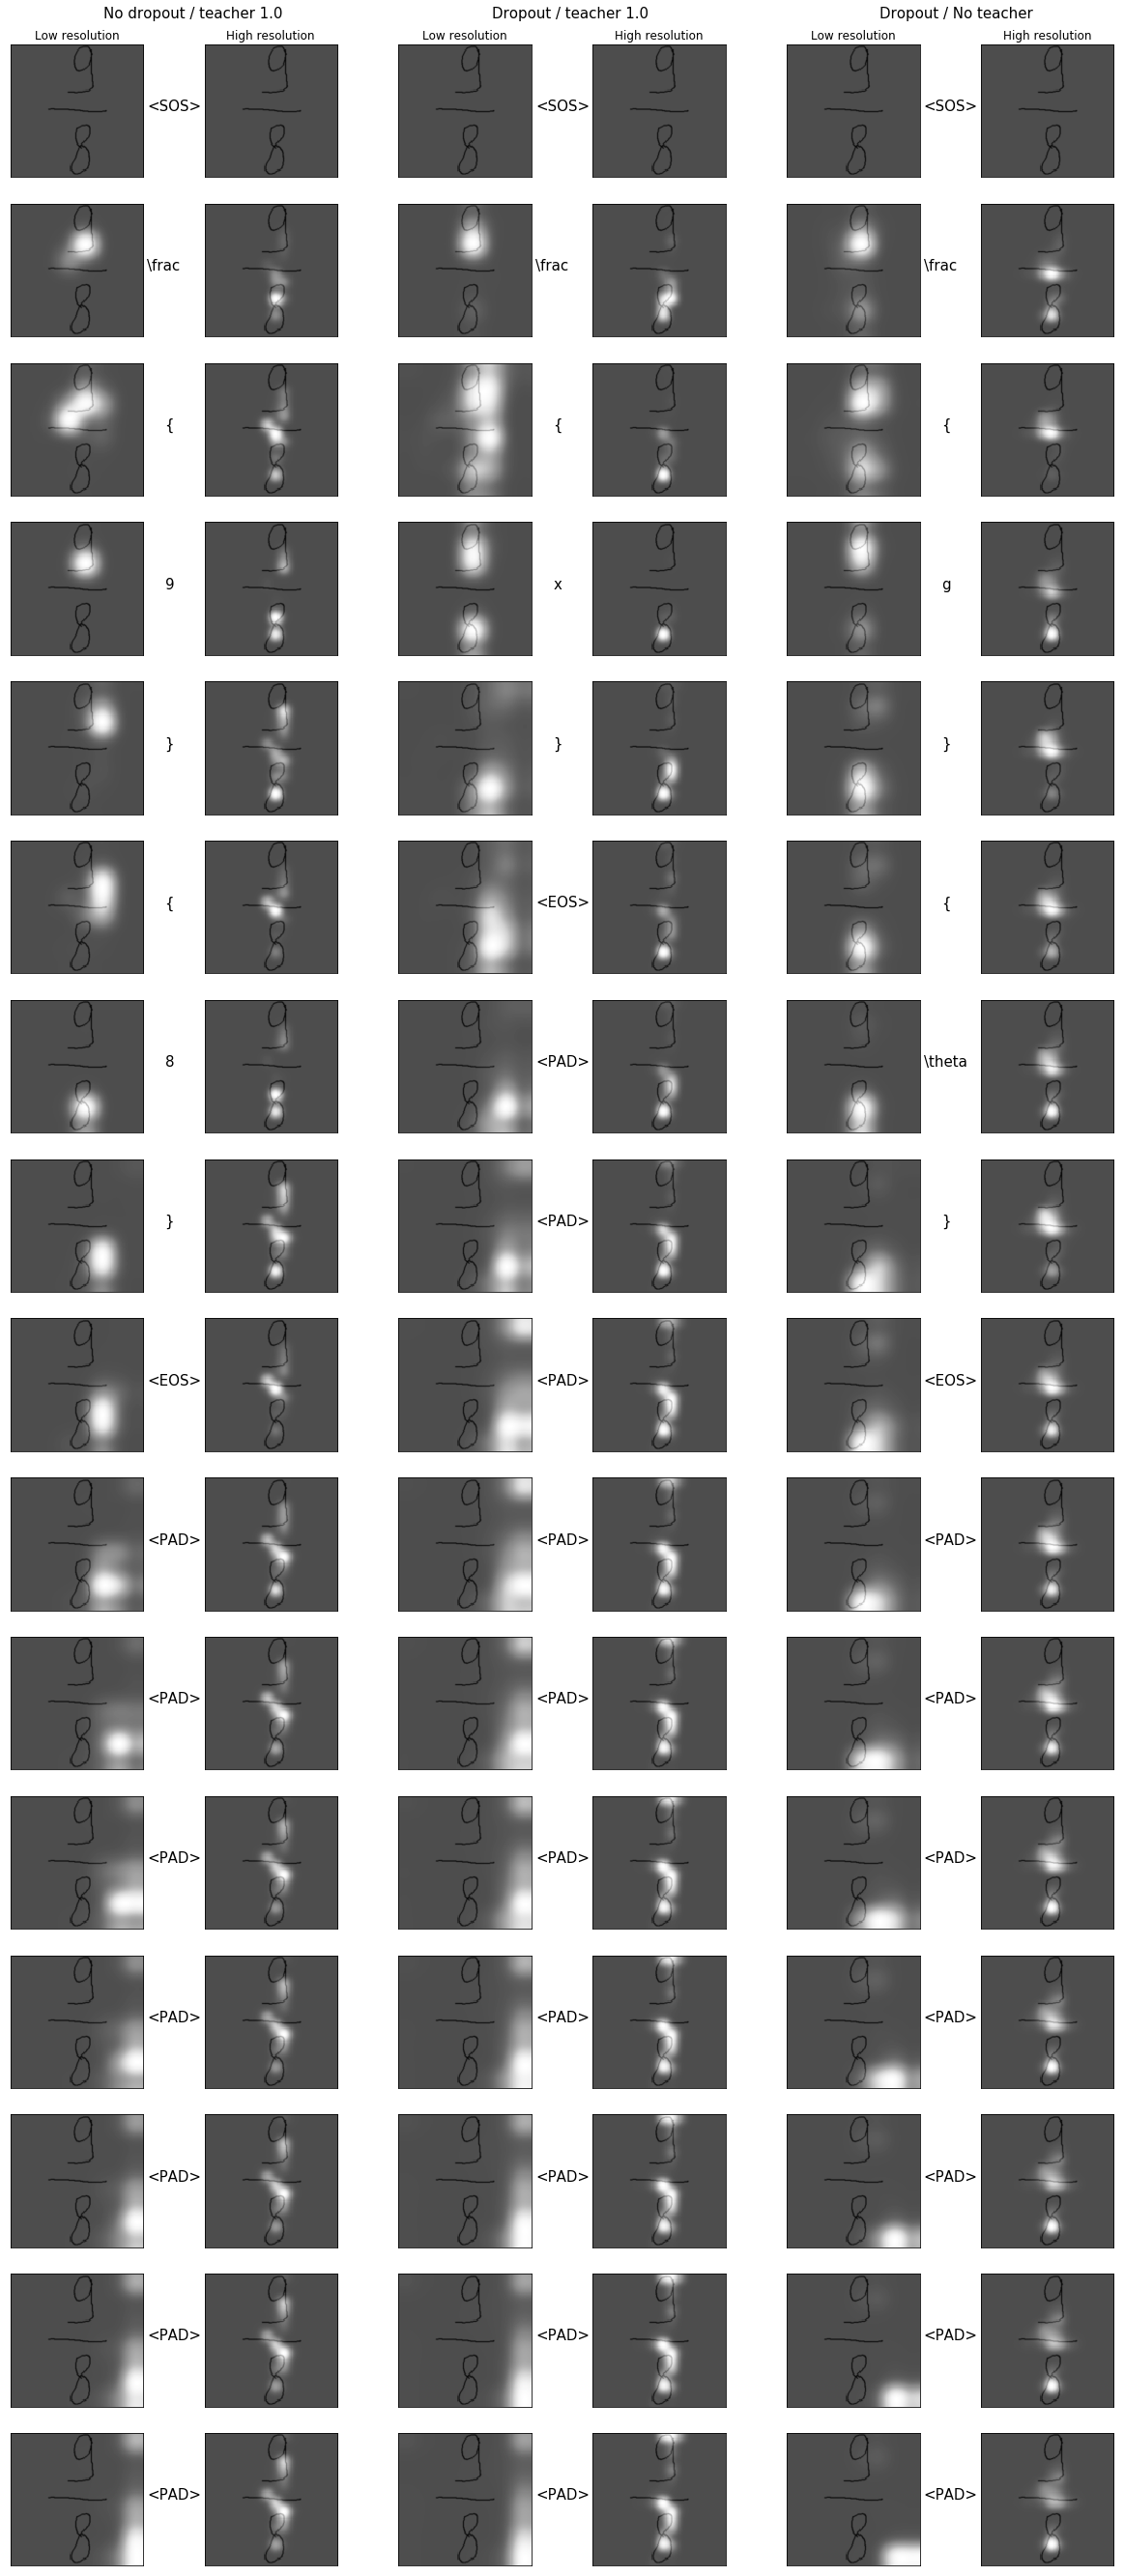

In [14]:
visualise_dataset(
    os.path.join("..", evaluate.test_sets["2016"]["groundtruth"]),
    os.path.join("..", evaluate.tokensfile),
    root=os.path.join("..", evaluate.test_sets["2016"]["root"]),
)

## Observations

Surprisingly, the first model without dropout, which was basically overfitting on the training set, is better at finding the symbols and performs better on the test sets. 

The high resolution attention seems to be more concentrated in the first model, whereas in the others it is quite scattered, which may make it less effective. In the latter models, the attention is still in the right places, but they have much more difficulties with predicting the correct symbol. For some reason `\sqrt` and curly brackets are preferred quite a lot. I can understand curly brackets, because they are used for grouping and could theoretically be used almost anywhere, but it's very unfortunate that it skips over the symbol. In the first model the attention stayed on the symbol until it was predicted, that means when an opening curly bracket is seen, it still stays on the symbol, but for the others that's not always the case. Additionally, they sometimes end the sequence way too early, when the attention is definitely still focusing on some symbol. Therefore the sequencing is problematic and needs to be improved.

From my observations, I would say that the low resolution attention is the primary focus to find the current symbol to predict and the high resolution attention assists in finding the context. For example for a binary operator it checks what's to the left and to the right of it, or when there is super or subscript it indicates whether the symbol is on the same height. It also kind of paves the way for upcoming predictions, as to where the low resolution should attend next.

In the paper they show the attention as if they were used separately. To be precise, the low resolution attention corrensponds to a regular DenseNet encoder, without the multi-scale branch, and the high resolution attention uses the multi-scale branch encoder, but depicts only the high resolution branch. It would have been interesting to see the low resolution attention as well in the multi-scale version. Either way, it looks like the high resolution might just as well be used alone in their examples.

![Attention visualisation](figures/attention-visualisation.png)

## Evaluation of the model

Different error rates are used to compare the results. The *Token error rate*
is the length normalised edit distance of the whole sequence, where each element
is one LaTeX token, that means that for example `\sum` is a single token. The
token also include the special tokens `<SOS>`, `<EOS>` and `<PAD>`. Since these
are not relevant for the LaTeX string, they are excluded in the *Token error
rate (no special tokens)* metric. Finally, the *Symbol error rate* is the length
normalised edit distance of the mathematical symbols in the LaTeX string. This
means that all tokens that are purely for formatting or grouping (e.g. `\left`,
`{`, `\mbox`), are excluded. Sub- and superscripts (i.e. `^` and `_`) are also
excluded, even though they technically change the semantics of the expression.

Besides the error rates, there is also the expression recognition rate, which is
how many expression have been recognised correctly, that is without a single
error in them.

### Sequence example

`\mbox{\cos} \left( x + y \right)`

| All tokens      | No special tokens   | Symbols   |
| --------------- | ------------------- | --------- |
| `<SOS>`         | `\mbox`             | `\cos`    |
| `\mbox`         | `{`                 | `(`       |
| `{`             | `\cos`              | `x`       |
| `\cos`          | `\left`             | `+`       |
| `\left`         | `(`                 | `y`       |
| `(`             | `x`                 | `)`       |
| `x`             | `+`                 |
| `+`             | `y`                 |
| `y`             | `\right`            |
| `\right`        | `)`                 |
| `)`             |                     |
| `<EOS>`         |                     |
| `<PAD>`         |                     |
| `<PAD>`         |                     |

### Training set

| Model                       | Token error rate   | Token error rate (no special tokens)   | Symbol error rate   |
|-----------------------------|--------------------|----------------------------------------|---------------------|
| No Dropout / with teacher   |  2.50%             |  3.81%                                 |  4.79%              |
| With Dropout / with teacher | 45.02%             | 62.86%                                 | 62.40%              |
| With Dropout / No teacher   | 48.23%             | 70.16%                                 | 77.80%              |

| Model                       | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|-----------------------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout / with teacher   | 91.46%              | 91.46%                                  | 92.08%                        |
| With Dropout / with teacher |  3.53%              |  3.53%                                  |  4.09%                        |
| With Dropout / No teacher   |  1.02%              |  1.02%                                  |  1.36%                        |

### Test set 2013

| Model                       | Token error rate   | Token error rate (no special tokens)   | Symbol error rate   |
|-----------------------------|--------------------|----------------------------------------|---------------------|
| No Dropout / with teacher   | 40.07%             | 65.15%                                 | 55.89%              |
| With Dropout / with teacher | 47.50%             | 77.76%                                 | 78.88%              |
| With Dropout / No teacher   | 48.38%             | 82.36%                                 | 88.10%              |

| Model                       | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|-----------------------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout / with teacher   |  4.32%              |  4.32%                                  |  9.68%                        |
| With Dropout / with teacher |  0.74%              |  0.74%                                  |  0.74%                        |
| With Dropout / No teacher   |  0.00%              |  0.00%                                  |  0.00%                        |

### Test set 2014

| Model                       | Token error rate   | Token error rate (no special tokens)   | Symbol error rate   |
|-----------------------------|--------------------|----------------------------------------|---------------------|
| No Dropout / with teacher   | 40.26%             | 65.05%                                 | 56.63%              |
| With Dropout / with teacher | 47.24%             | 77.44%                                 | 78.37%              |
| With Dropout / No teacher   | 48.25%             | 81.18%                                 | 86.37%              |

| Model                       | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|-----------------------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout / with teacher   |  3.54%              |  3.54%                                  |  7.80%                        |
| With Dropout / with teacher |  3.04%              |  3.04%                                  |  3.04%                        |
| With Dropout / No teacher   |  0.00%              |  0.00%                                  |  0.10%                        |

### Test set 2016

| Model                       | Token error rate   | Token error rate (no special tokens)   | Symbol error rate   |
|-----------------------------|--------------------|----------------------------------------|---------------------|
| No Dropout / with teacher   | 39.30%             | 63.15%                                 | 55.55%              |
| With Dropout / with teacher | 47.07%             | 74.97%                                 | 75.80%              |
| With Dropout / No teacher   | 48.86%             | 80.90%                                 | 84.10%              |

| Model                       | Correct expressions | Correct expressions (no special tokens) | Correct expressions (Symbols) |
|-----------------------------|---------------------|-----------------------------------------|-------------------------------|
| No Dropout / with teacher   |  4.62%              |  4.62%                                  |  7.93%                        |
| With Dropout / with teacher |  0.61%              |  0.61%                                  |  0.95%                        |
| With Dropout / No teacher   |  0.00%              |  0.00%                                  |  0.08%                        |

## Conclusion

### Attention

I'm surprised how well the attention seems to be able to focus, even though the
high resolution attention is sometimes a bit too far away from the current
symbol. Sometimes that is a good thing, because it can determine what might be
coming, for example for closing parentheses.

### Models

While the model without dropout reached a high recognition rate on the training
set, it has little success on the test sets. This was totally expected, since it
was supposed to overfit. But unfortunately, the dropout models are strictly
worse, because they just didn't learn properly. This is most certainly due to
the fact, that there is too much dropout. I have to assume that they didn't
express themselves rigorously, because it says:

> [...] we added a dropout layer [30] after each convolutional layer and set the
> drop rate to 0.2.

That is exactly what I did, a dropout after every single convolutional layer.
Usually in a DenseNet, dropout is only applied after each dense layer, which
corresponds to one layer within a dense block. In our case this is a bottleneck
layer. 

You might think that convolutional layer may refer to the dense/bottleneck layer
but from the following excerpt, it clearly shows, that it is not the case.

> The growth rate k = 24 and the depth (number of convolution layers) of each
> block D = 32 which means each block has 16 1 × 1 convolution layers and 16
> 3 × 3 convolution layers. A batch normalization layer [24] and a ReLU
> activation layer [25] are performed after each convolution layer
> consecutively.

It will be changed to follow the standard DenseNet architecture.
I wasn't fond of their version of the dropout when I implemented it, but
I thought I should follow the paper anyway to try to recreate their findings.
Hopefully, the new dropout version will be better and it will be able to learn
correctly.

### Sequence length

One problematic aspect is the difference in sequence length regarding different
LaTeX representations that render the same thing. For example `\frac {{{x}}} {y}`
renders the same as `\frac x y` but having a length difference of
8 tokens. Technically, it could end with `\frac {{{` because it only expects
3 tokens (plus 1 because there would be an `<EOS>` token, but that would be
used to see another token instead of ending the sequence). Some sort of
upper limit or so would probably be better in the evaluation. Fortunately,
some of that is accommodated by the padding, because fairly often the sequences
need extra padding to match the longest sequence in the batch. In that case
the smaller ones, which are padded, have more room for formatting tokens.
There is a decent chance that the previous example would be able to predict the
full `\frac {{{x}}} {y}`. Ideally, such extraneous formatting isn't present at
all, and for all other cases the padding should provide a decent solution.

## Next steps

### Evaluate the fixed dropout version (standard DenseNet dropout)

Evaluating the fixed dropout version to see whether that helps and to see how
well it performs.

### Beam search

To improve the evaluation accuracy, it would be a good idea to use beam search,
especially since LaTeX can have different representation of the same result.
In the paper they also use it, so it is expected to improve the performance.
This should definitely help with the fact that curly brackets are used so often.

### CROHME evaluation tool

Currently I'm not using the CROHME evaluation tool, since it expects more than
just the MathML representation of the LaTeX string (some annotations etc.).
I'll look into their format a bit more, but I'm not entirely sure if it would
provide any more information than what I already have, especially since there
are no on-line properties, which means that it basically tells you the
expression recognition rate.


### Tutoring data

I have to process the data that we got from the tutoring system. There are
some Chinese characters in there and I will exclude them and focus on just the
mathematical expressions, since Chinese handwritten character recognition is
a difficult problem on its own. The data in general is less complex than the
CROHME one, so hopefully it will have some good results.